#**AIRBNB NEW USER PREDICTION**#

**Business Problem:**

>Airbnb has consistently been one of the best site for travellers which helps them to find hotels, room stays and tourism activities that suits the travellers wish. Airbnb has lot of improvised  features that help travellers filter, sort and choose the best that fits their interest. It is working on enhancing the user interface in a way that could reduce the searching time of the users by providing them with the services that they expect. Thereby they increase their quality of service. 



**Problem Statement:**


> Here we have to predict the desired destination of the first time users, thereby we can have the knowledge of the what the user expects and can show them with the more personalised content, thus decreasing the average time of the first booking. We are provided with user's basic details (like browser, devcie type, etc) and also browser sessions data. 



**Constrains:**


1.   Low Latency is required.
2.   Cost of misclassification is not going to affect a lot. In case of misclassification users can search for their choices.
3.   Interpretability is not required. 
 


**Raw Data Analysis:**

We have 5 csv files : train_users_2.csv, test_users.csv, sessions.csv, 
age_gender_bkts.csv, countries.csv

train_users_2.csv: Contains basic details of users like gender,language, browser used, device used etc.

sessions.csv: Contains browser session of the user. user_id can be joined with the id of the train_users_2 dataset. This contains fields like action (action done by the user), action_type (type of the action), action_detail, device_type of the user and secs_elapsed (seconds elapsed for each action).

countries.csv: Has the information of each countries (ie latitude, longitude, country's language and the language difference between english and the native language

age_gender_bkts: This file has the information of number of people within the bucket range for each country destination and for each gender.

test_users.csv: Has the same informations as the train_users_2 file. User id in test_users file are also in sessions.csv file.


**Evaluation Metric:**

NDCG score(Normalised Discounted Cummulative Gain). Suggested by kaggle.

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
%cd /root/
!kaggle competitions download -c 'airbnb-recruiting-new-user-bookings'

/root
  0% 0.00/546 [00:00<?, ?B/s]
100% 546/546 [00:00<00:00, 912kB/s]
  0% 0.00/478k [00:00<?, ?B/s]
100% 478k/478k [00:00<00:00, 66.7MB/s]
 88% 52.0M/59.1M [00:00<00:00, 158MB/s]
100% 59.1M/59.1M [00:00<00:00, 168MB/s]
  0% 0.00/2.46k [00:00<?, ?B/s]
100% 2.46k/2.46k [00:00<00:00, 2.29MB/s]
  0% 0.00/1.03M [00:00<?, ?B/s]
100% 1.03M/1.03M [00:00<00:00, 147MB/s]
  0% 0.00/4.07M [00:00<?, ?B/s]
100% 4.07M/4.07M [00:00<00:00, 134MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals.joblib import dump
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
%cd /root

/root


In [ ]:
train_data=pd.read_csv('train_users_2.csv.zip',compression='zip')
sessions_data=pd.read_csv('sessions.csv.zip',compression='zip')
test_data=pd.read_csv('test_users.csv.zip',compression='zip')

In [ ]:
train_data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
train_data.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [ ]:
print("Shape of train data:",train_data.shape)
print('Shape of test data:',test_data.shape)

Shape of train data: (213451, 16)
Shape of test data: (62096, 15)


In [ ]:
print("number of null values in each column:\n")
train_data.isna().sum()

number of null values in each column:



id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

Here three column (date_first_booking,age,first_affliate_tracked) have missing values.

Let us check how many data points we have for each classes.

Text(0, 0.5, 'Number of users')

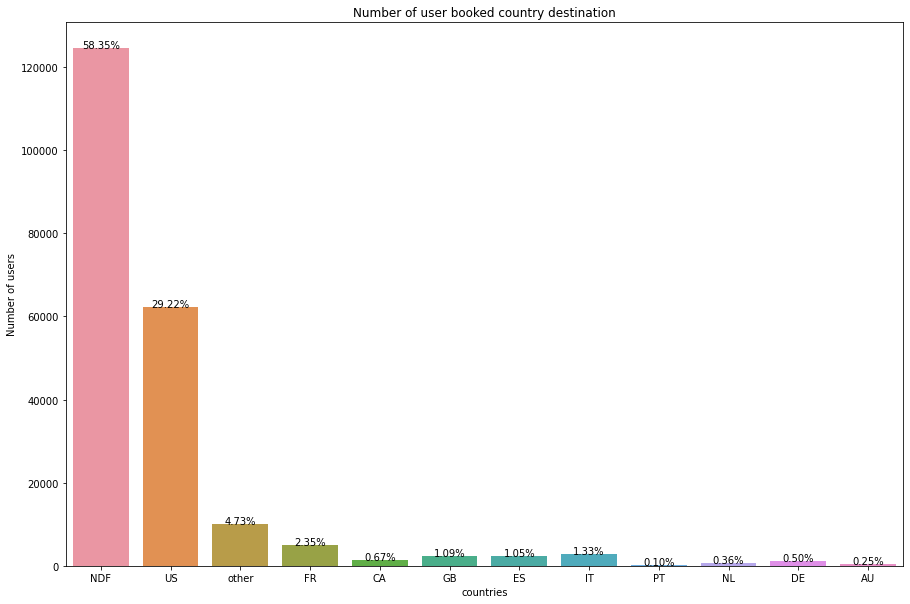

In [ ]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=train_data,x='country_destination')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.title('Number of user booked country destination')
plt.xlabel("countries")
plt.ylabel("Number of users")

From the above graph we can see that 58.35% of data points have NDF as destination, 29.22% of data points have US as destination, 4.73% of data points have Others as destination and so on. From this we can infer that the data is heavily imbalanced between classes. 

#Date account created#

Let us begin with the feature Date account created

In [ ]:
train_data['date_account_created']=pd.to_datetime(train_data['date_account_created'])

Let us extract year,month and the day of the user's account creation day.

In [ ]:
train_data['year_account_created']=pd.DatetimeIndex(train_data['date_account_created']).year
train_data['month_account_created']=pd.DatetimeIndex(train_data['date_account_created']).month
train_data['day_account_created']=pd.DatetimeIndex(train_data['date_account_created']).dayofweek

##Analysis on User's account creation date##

Text(0, 0.5, 'Number of new users users')

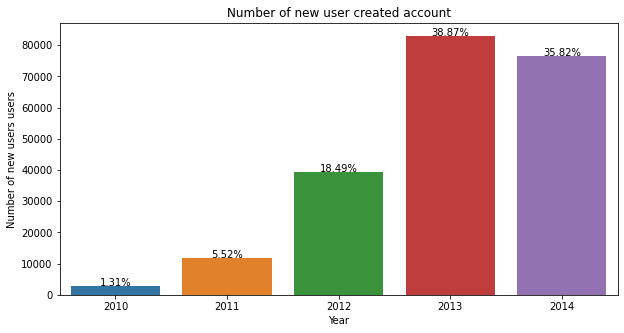

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.countplot(data=train_data,x='year_account_created')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.title('Number of new user created account')
plt.xlabel("Year")
plt.ylabel("Number of new users users")

Each year we could see that the number of users gets increased but in 2014 we could see some reduction because in training data we have till the 6th month of 2014.

Let us analyse the number of new user creating account on each month.

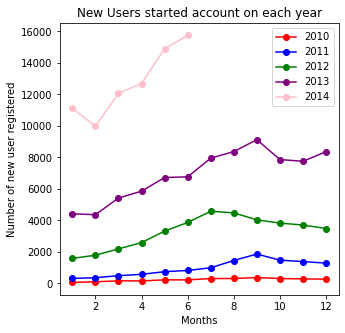

In [ ]:
#Here data_2010 contains the information of number of users created account on each month on 2010. Similarly for all the years is done

data_2010=train_data[train_data['year_account_created']==2010]['month_account_created'].value_counts().sort_index()
data_2011=train_data[train_data['year_account_created']==2011]['month_account_created'].value_counts().sort_index()
data_2012=train_data[train_data['year_account_created']==2012]['month_account_created'].value_counts().sort_index()
data_2013=train_data[train_data['year_account_created']==2013]['month_account_created'].value_counts().sort_index()
data_2014=train_data[train_data['year_account_created']==2014]['month_account_created'].value_counts().sort_index()
years=['2010','2011','2012','2013','2014']
data=[data_2010,data_2011,data_2012,data_2013,data_2014]
colors=['red','blue','green','purple','pink']

fig=plt.figure(figsize=(5,5))
k=0
for i in range(5):
  plt.plot(data[i].keys(),data[i],color=colors[i],label=years[i],marker='o')
plt.xlabel('Months')
plt.ylabel("Number of new user registered")
plt.title('New Users started account on each year')
plt.legend()

From the above graph we can see that between 6th,7th,8th and 9th months there are lot of new users who created their accounts. During that time people prefer to go to some other places. This graph shows us seasonal changes.

Lets us analyse how days impact in user account creation.


([<matplotlib.axis.XTick at 0x7f8b641a1950>,
 [Text(0, 0, 'Monday'),
  Text(0, 0, 'Tuesday'),
  Text(0, 0, 'Wednesday'),
  Text(0, 0, 'Thursday'),
  Text(0, 0, 'Friday'),
  Text(0, 0, 'Saturday'),
  Text(0, 0, 'Sunday')])

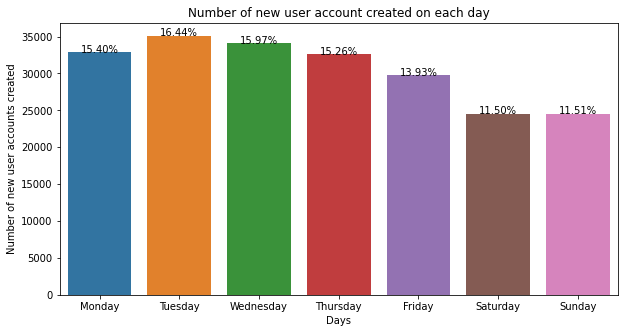

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.countplot(data=train_data,x='day_account_created')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.title("Number of new user account created on each day")
plt.xlabel("Days")
plt.ylabel("Number of new user accounts created")
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

Here we can see that a rise in new user account creation after sunday. Weekdays are more preferred than weekends for the creation of account.

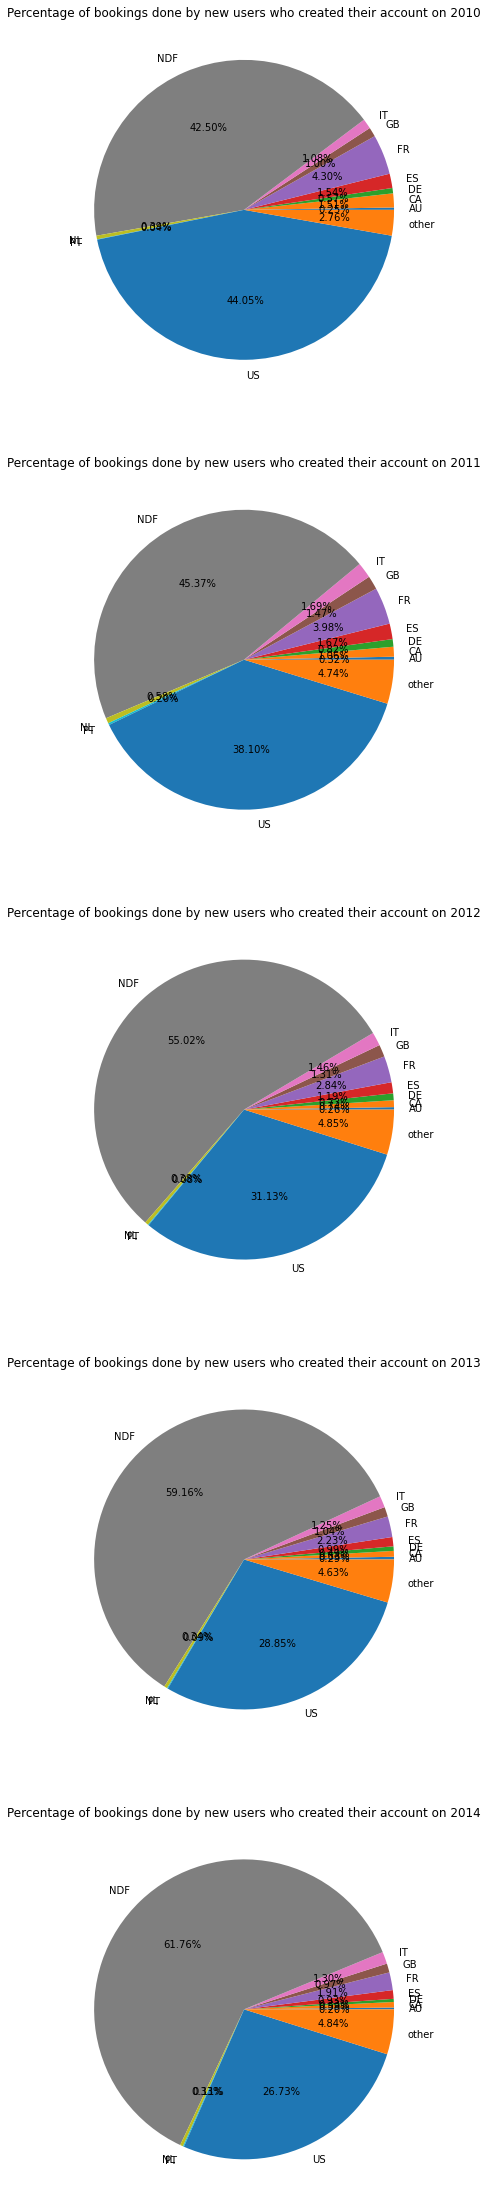

In [ ]:
data_2010=train_data[train_data['year_account_created']==2010]['country_destination'].value_counts().sort_index()
data_2011=train_data[train_data['year_account_created']==2011]['country_destination'].value_counts().sort_index()
data_2012=train_data[train_data['year_account_created']==2012]['country_destination'].value_counts().sort_index()
data_2013=train_data[train_data['year_account_created']==2013]['country_destination'].value_counts().sort_index()
data_2014=train_data[train_data['year_account_created']==2014]['country_destination'].value_counts().sort_index()
data=[data_2010,data_2011,data_2012,data_2013,data_2014]

fig,ax=plt.subplots(5,figsize=(20,20))
fig.set_figheight(40)
fig.set_figwidth(40)
for i in range(ax.shape[0]):
  ax[i].pie(data[i].values,labels=data[i].index,autopct='%1.2f%%')
  ax[i].set_title("Percentage of bookings done by new users who created their account on {}".format(years[i]))


From the above pie chart we can notice that each year the percentage of ndf increases, while US decreases and the rest other countries tend to be almost same. Though each year we have increase in the number of users who created account many have not booked to any destination.

Lets us see how a new user registerd at a particular month chooses his preference of destination.

In [ ]:
#Here US_2010 has the month wise record of new user's who created account on 2010 and choosed US as country destination
#Similarly for NDF and Others country destinations
#Here Others_2010 represents all other country destination except for US and also the class NDF.  

US_2010=[]
NDF_2010=[]
Others_2010=[]
for month in range(1,13):
  data=train_data[train_data['year_account_created']==2010][['month_account_created','country_destination']].value_counts().sort_index()[month]
  NDF_2010.append(data['NDF'])
  US_2010.append(data['US'])
  others=data.sum()-(data['NDF']+data['US'])
  Others_2010.append(others)

US_2011=[]
NDF_2011=[]
Others_2011=[]
for month in range(1,13):
  data=train_data[train_data['year_account_created']==2011][['month_account_created','country_destination']].value_counts().sort_index()[month]
  NDF_2011.append(data['NDF'])
  US_2011.append(data['US'])
  others=data.sum()-(data['NDF']+data['US'])
  Others_2011.append(others)

US_2012=[]
NDF_2012=[]
Others_2012=[]
for month in range(1,13):
  data=train_data[train_data['year_account_created']==2012][['month_account_created','country_destination']].value_counts().sort_index()[month]
  NDF_2012.append(data['NDF'])
  US_2012.append(data['US'])
  others=data.sum()-(data['NDF']+data['US'])
  Others_2012.append(others)

US_2013=[]
NDF_2013=[]
Others_2013=[]
for month in range(1,13):
  data=train_data[train_data['year_account_created']==2013][['month_account_created','country_destination']].value_counts().sort_index()[month]
  NDF_2013.append(data['NDF'])
  US_2013.append(data['US'])
  others=data.sum()-(data['NDF']+data['US'])
  Others_2013.append(others)

US_2014=[]
NDF_2014=[]
Others_2014=[]
for month in range(1,7):
  data=train_data[train_data['year_account_created']==2014][['month_account_created','country_destination']].value_counts().sort_index()[month]
  NDF_2014.append(data['NDF'])
  US_2014.append(data['US'])
  others=data.sum()-(data['NDF']+data['US'])
  Others_2014.append(others)

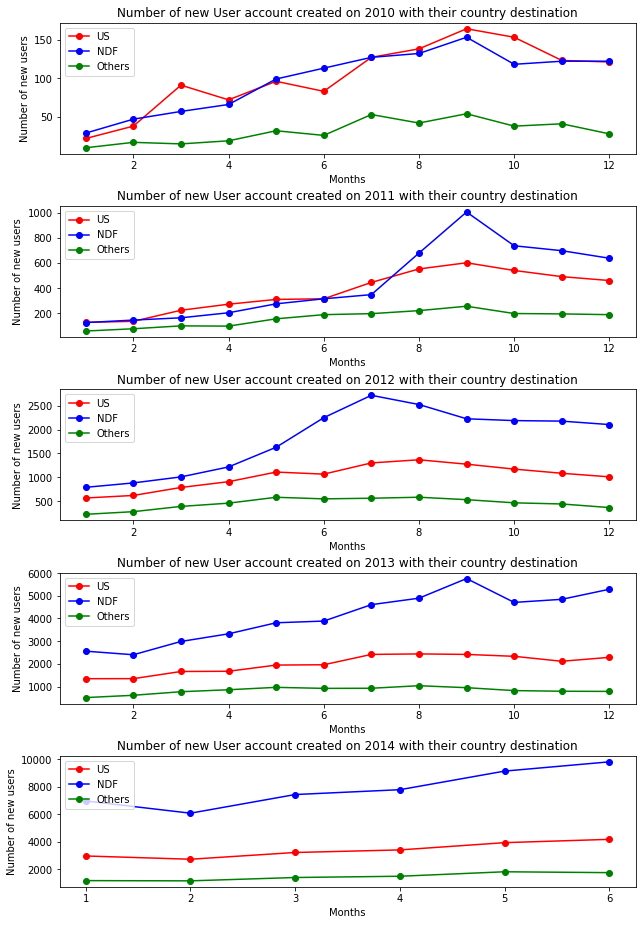

In [ ]:
years=['2010','2011','2012','2013','2014']
overall_plots=[[US_2010,NDF_2010,Others_2010],[US_2011,NDF_2011,Others_2011],[US_2012,NDF_2012,Others_2012],
               [US_2013,NDF_2013,Others_2013],[US_2014,NDF_2014,Others_2014]]

fig,ax=plt.subplots(5,figsize=(10,15))
row=0
column=0
for i in range(ax.shape[0]):
  ax[i].plot(np.arange(1,len(overall_plots[i][0])+1),overall_plots[i][0],'red',label='US',marker='o')
  ax[i].plot(np.arange(1,len(overall_plots[i][1])+1),overall_plots[i][1],'blue',label='NDF',marker='o')
  ax[i].plot(np.arange(1,len(overall_plots[i][2])+1),overall_plots[i][2],'green',label='Others',marker='o')
  ax[i].set_xlabel('Months')
  ax[i].set_ylabel("Number of new users")
  ax[i].set_title("Number of new User account created on {} with their country destination".format(years[i]))
  ax[i].legend(loc='upper left')
  column+=1
  if column%2==0:
    column=0
    row+=1
  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

From the above analysis we can see that each year during the months between 6 to 9 the number of users who doesn't make any bookings increases than the number users who done  bookings. Though there is slight increase in the users who book to US subsequently NDF is much becomes higher and higher in each year.

Let us analyse how days determine one's destination.

([<matplotlib.axis.XTick at 0x7f8b63e1e210>,
 [Text(0, 0, 'Monday'),
  Text(0, 0, 'Tuesday'),
  Text(0, 0, 'Wednesday'),
  Text(0, 0, 'Thursday'),
  Text(0, 0, 'Friday'),
  Text(0, 0, 'Saturday'),
  Text(0, 0, 'Sunday')])

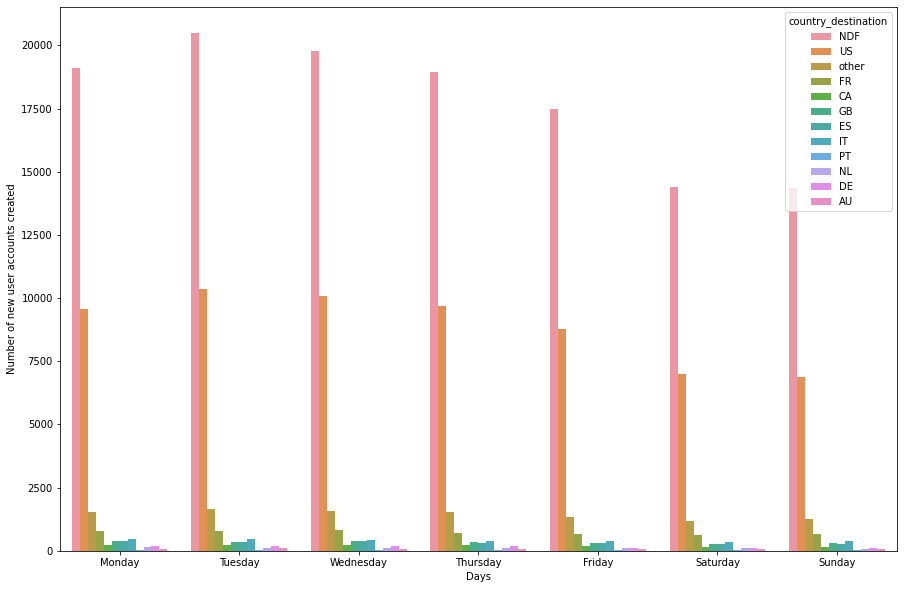

In [ ]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=train_data,x='day_account_created',hue='country_destination',)
plt.xlabel("Days")
plt.ylabel("Number of new user accounts created")
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

From the above graph we can see almost all country destination follows same pattern. By viewing in terms of percentage we could get some insights.

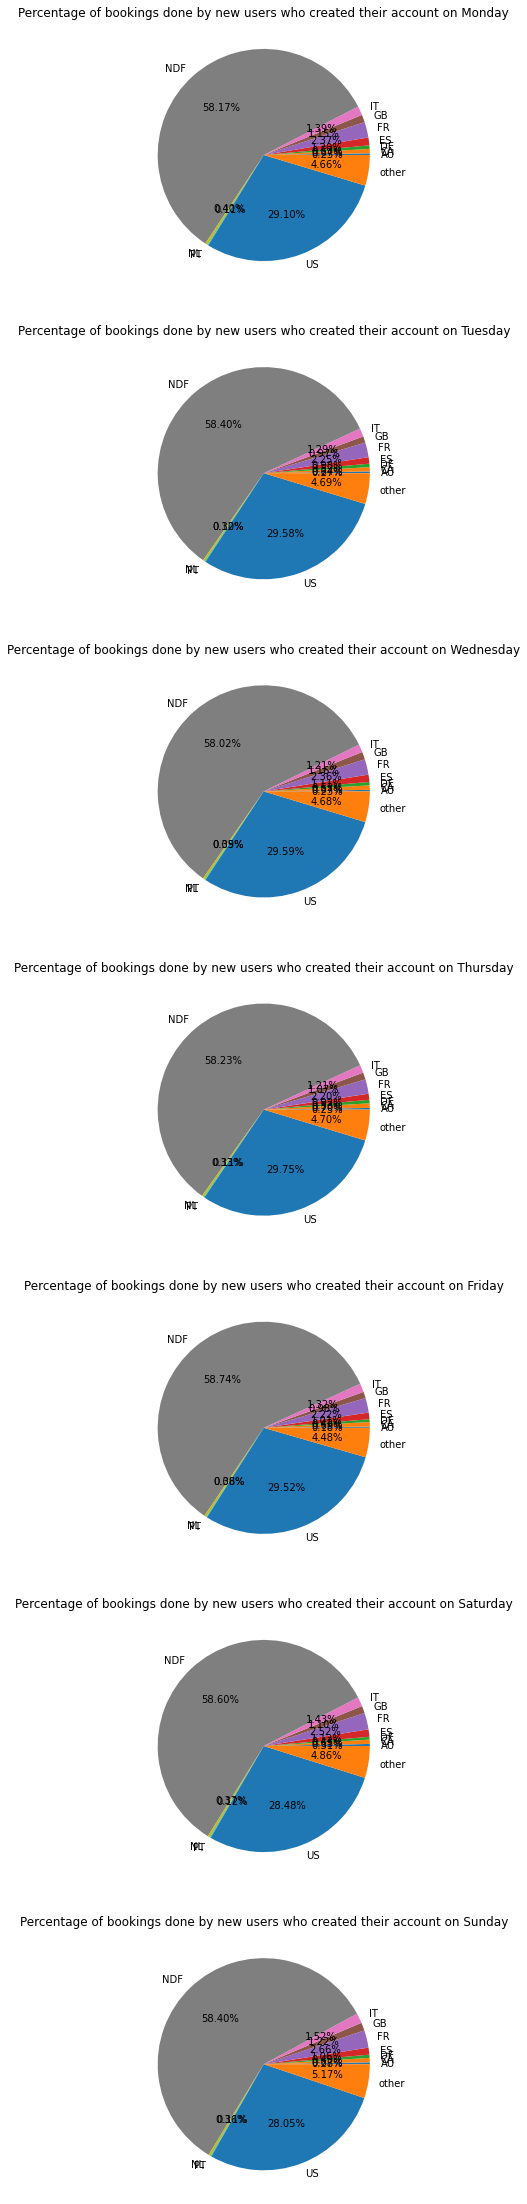

In [ ]:
data_mon=train_data[train_data['day_account_created']==0]['country_destination'].value_counts().sort_index()
data_tue=train_data[train_data['day_account_created']==1]['country_destination'].value_counts().sort_index()
data_wed=train_data[train_data['day_account_created']==2]['country_destination'].value_counts().sort_index()
data_thu=train_data[train_data['day_account_created']==3]['country_destination'].value_counts().sort_index()
data_fri=train_data[train_data['day_account_created']==4]['country_destination'].value_counts().sort_index()
data_sat=train_data[train_data['day_account_created']==5]['country_destination'].value_counts().sort_index()
data_sun=train_data[train_data['day_account_created']==6]['country_destination'].value_counts().sort_index()
data=[data_mon,data_tue,data_wed,data_thu,data_fri,data_sat,data_sun]
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig,ax=plt.subplots(7,figsize=(20,20))
fig.set_figheight(40)
fig.set_figwidth(40)
for i in range(ax.shape[0]):
  ax[i].pie(data[i].values,labels=data[i].index,autopct='%1.2f%%')
  ax[i].set_title("Percentage of bookings done by new users who created their account on {}".format(days[i]))


From the above pie chart we can see that people who prefer to go to other countries(ie the countries that are not in the classes)(orange pie) many used to create their account on sundays. As mentioned in the ablove graph we could see almost similar patterns on all days for destination preferences.

Let us analyse user first instance into airbnb.

#Timestamp first active#

In [ ]:
train_data['timestamp_first_active']=pd.to_datetime(train_data['timestamp_first_active'],format='%Y%m%d%H%M%S')

In [ ]:
train_data['year_first_active']=pd.DatetimeIndex(train_data['timestamp_first_active']).year
train_data['month_first_active']=pd.DatetimeIndex(train_data['timestamp_first_active']).month
train_data['day_first_active']=pd.DatetimeIndex(train_data['timestamp_first_active']).dayofweek
train_data['hour_first_active']=pd.DatetimeIndex(train_data['timestamp_first_active']).hour

##Analysis on user's first active##

Text(0, 0.5, 'Number of users ')

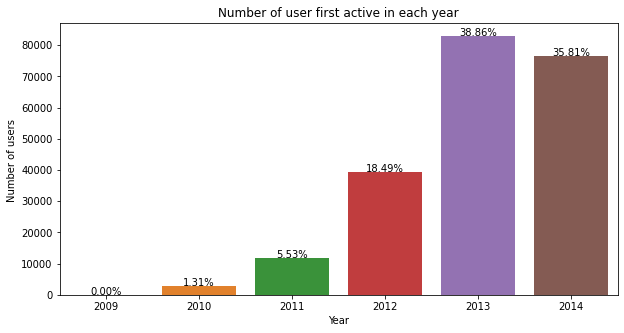

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.countplot(data=train_data,x='year_first_active')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.title('Number of user first active in each year')
plt.xlabel("Year")
plt.ylabel("Number of users ")

We can see that very few people went through Airbnb before they start their account in 2009 and all other graphs follow the similar percentage as year_account_created. 

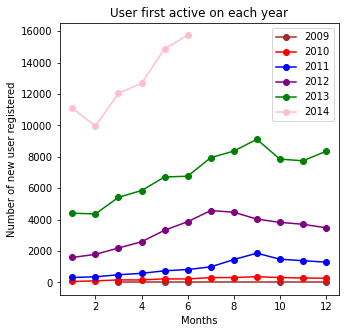

In [ ]:
data_2009=train_data[train_data['year_first_active']==2009]['month_first_active'].value_counts().sort_index()
data_2010=train_data[train_data['year_first_active']==2010]['month_first_active'].value_counts().sort_index()
data_2011=train_data[train_data['year_first_active']==2011]['month_first_active'].value_counts().sort_index()
data_2012=train_data[train_data['year_first_active']==2012]['month_first_active'].value_counts().sort_index()
data_2013=train_data[train_data['year_first_active']==2013]['month_first_active'].value_counts().sort_index()
data_2014=train_data[train_data['year_first_active']==2014]['month_first_active'].value_counts().sort_index()
data=[data_2009,data_2010,data_2011,data_2012,data_2013,data_2014]
years=['2009','2010','2011','2012','2013','2014']
colors=['brown','red','blue','purple','green','pink']

fig=plt.figure(figsize=(5,5))
k=0
for i in range(6):
  plt.plot(data[i].keys(),data[i],color=colors[i],label=years[i],marker='o')
plt.xlabel('Months')
plt.ylabel("Number of new user registered")
plt.title('User first active on each year')
plt.legend()

Here also we can see the same behavior as month_account_created.

([<matplotlib.axis.XTick at 0x7f8b62409690>,
 [Text(0, 0, 'Monday'),
  Text(0, 0, 'Tuesday'),
  Text(0, 0, 'Wednesday'),
  Text(0, 0, 'Thursday'),
  Text(0, 0, 'Friday'),
  Text(0, 0, 'Saturday'),
  Text(0, 0, 'Sunday')])

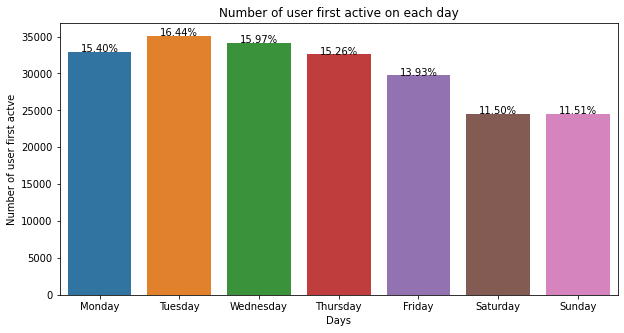

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.countplot(data=train_data,x='day_first_active')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.title("Number of user first active on each day")
plt.xlabel("Days")
plt.ylabel("Number of user first actve")
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

From the above 3 diagrams we can infer that the user's first instance time behaves same as user's account creation date.

Let us analyse how hourly timing helps in finding one's decision.

Text(0, 0.5, 'Number of users ')

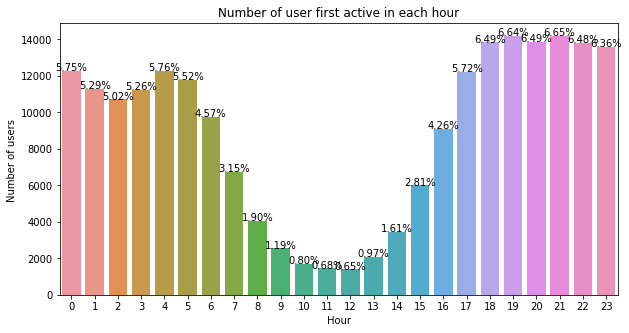

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.countplot(data=train_data,x='hour_first_active')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.title('Number of user first active in each hour')
plt.xlabel("Hour")
plt.ylabel("Number of users ")

From the above diagram we can see that users surf thorugh aibnb during night hours. We can see that people who are using the service between 12:00 am to 6:00 am is higher than people using it between 8:00 am to 2:00 pm. Early mornings and afternoons are the least recorded. The reason might be it is working hours. Let us analyse how each hours behave each day.

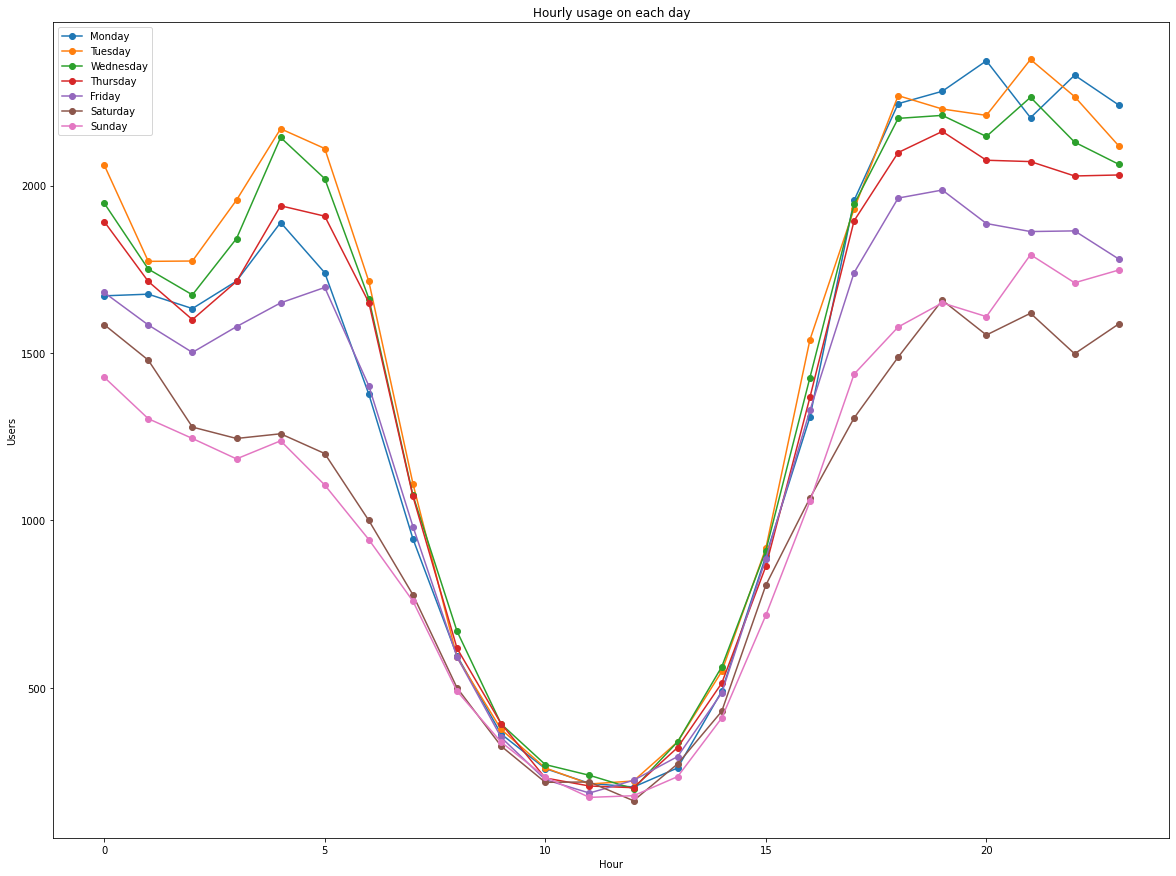

In [ ]:
#data_mon consists of hourly data (ie the total number of users who surfed at each hour ) of users
data_mon=train_data[train_data['day_first_active']==0]['hour_first_active'].value_counts().sort_index()
data_tue=train_data[train_data['day_first_active']==1]['hour_first_active'].value_counts().sort_index()
data_wed=train_data[train_data['day_first_active']==2]['hour_first_active'].value_counts().sort_index()
data_thu=train_data[train_data['day_first_active']==3]['hour_first_active'].value_counts().sort_index()
data_fri=train_data[train_data['day_first_active']==4]['hour_first_active'].value_counts().sort_index()
data_sat=train_data[train_data['day_first_active']==5]['hour_first_active'].value_counts().sort_index()
data_sun=train_data[train_data['day_first_active']==6]['hour_first_active'].value_counts().sort_index()
data=[data_mon,data_tue,data_wed,data_thu,data_fri,data_sat,data_sun]
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

plt.figure(figsize=(20,15))
for i in range(7):
  plt.plot(data[i].index,data[i].values,marker='o',label=days[i])
plt.title("Hourly usage on each day")
plt.xlabel('Hour')
plt.ylabel('Users')
plt.legend()

This diagram shows on each day how many people will visit the site at each hour. We could see that even on weekends people don't surf through airbnb during morning and afternon hours(which won't be their working hours). Let us analyse how hourly booking helps us in determining persons country preference.


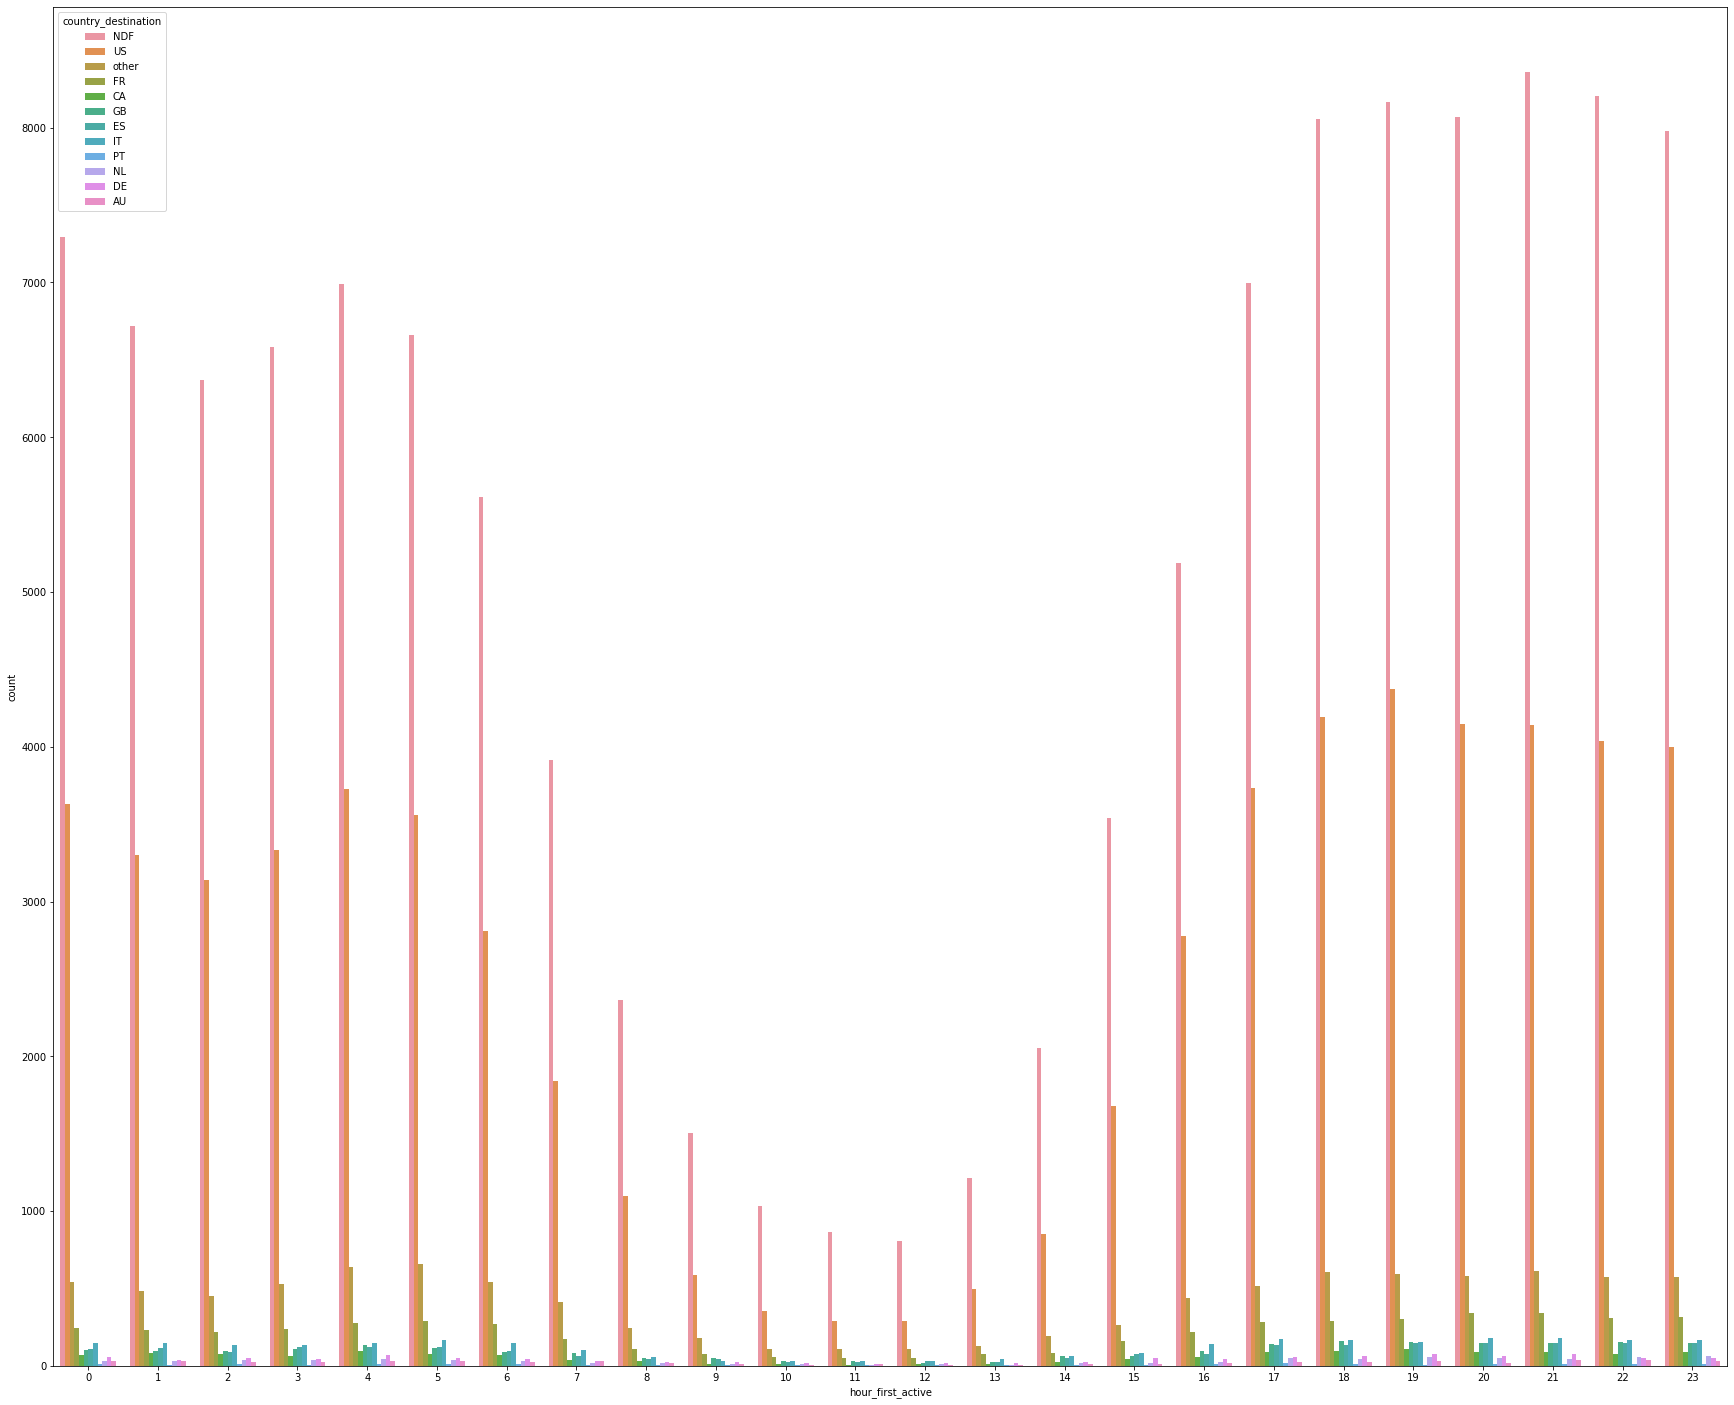

In [ ]:
plt.figure(figsize=(30,25))
sns.countplot(data=train_data,x='hour_first_active',hue='country_destination')

By using counts we can see similar trends for each country at each hour. Let us visualize in the form of pie chart.

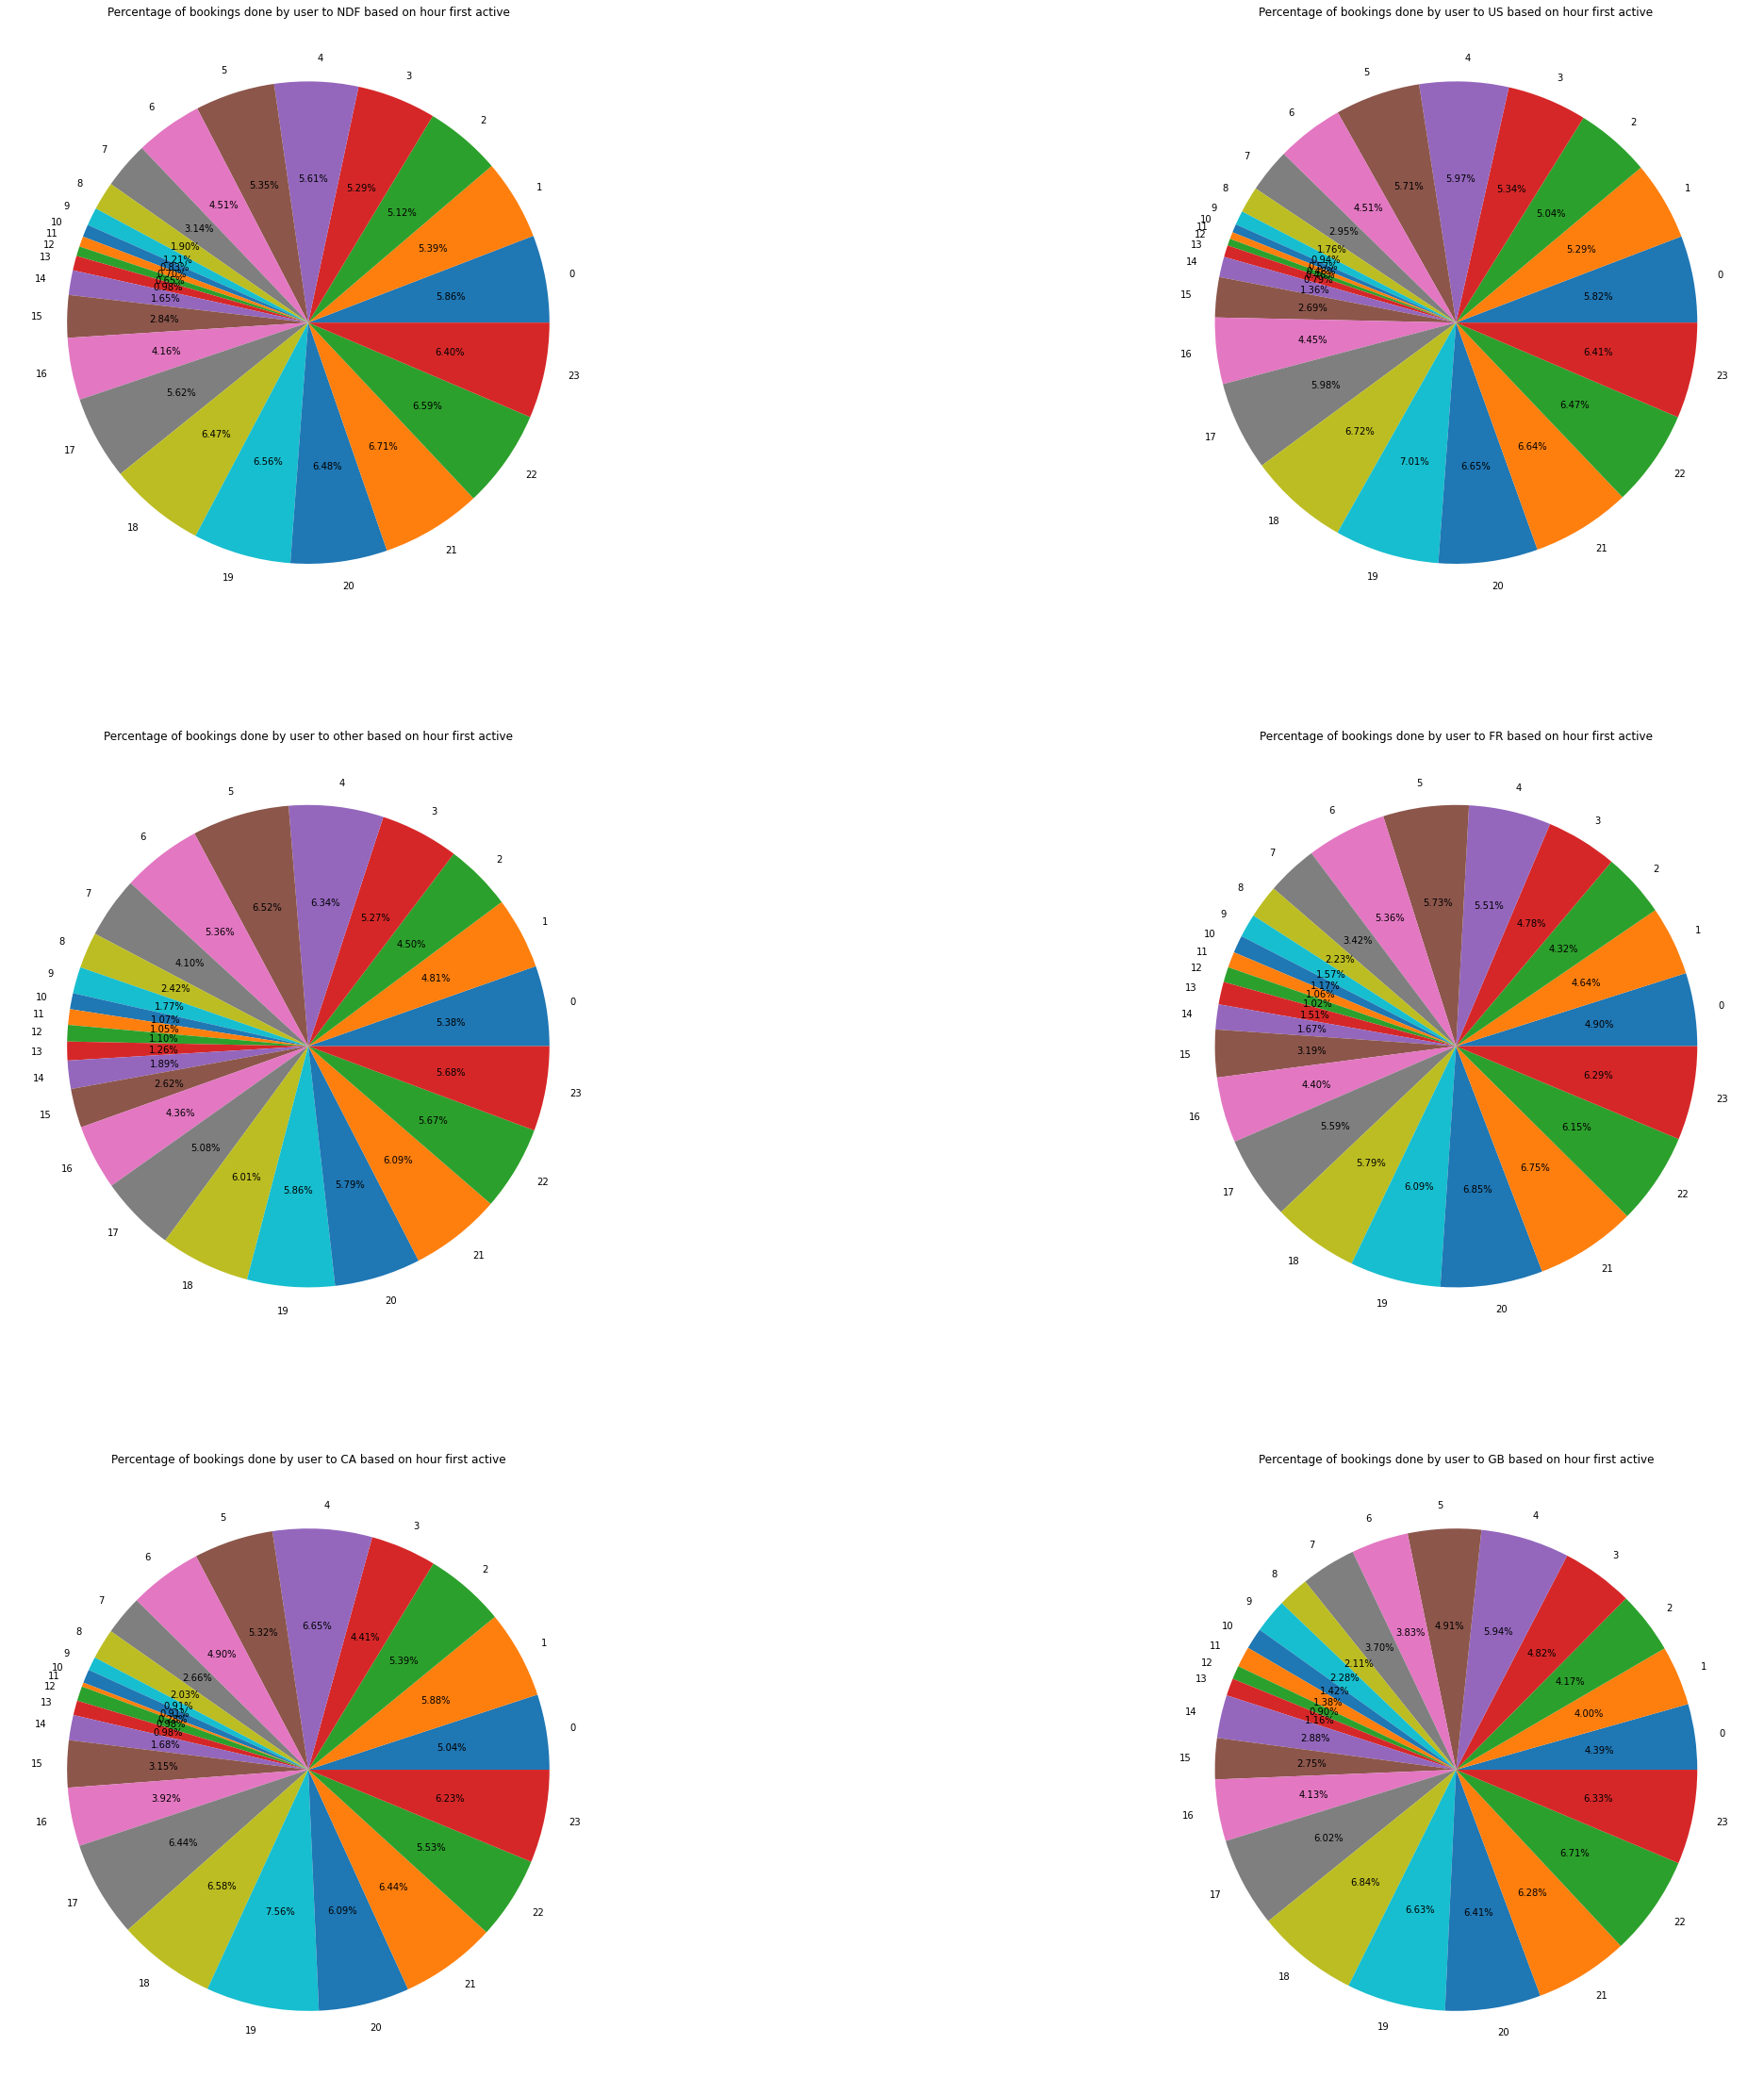

In [ ]:
#data_ndf contains hourly count of users whose country_destination in "NDF".
#Similarly we take for top 5 country destinations along with NDF.

data_ndf=train_data[train_data['country_destination']=='NDF']['hour_first_active'].value_counts().sort_index()
data_us=train_data[train_data['country_destination']=='US']['hour_first_active'].value_counts().sort_index()
data_ot=train_data[train_data['country_destination']=='other']['hour_first_active'].value_counts().sort_index()
data_fr=train_data[train_data['country_destination']=='FR']['hour_first_active'].value_counts().sort_index()
data_ca=train_data[train_data['country_destination']=='CA']['hour_first_active'].value_counts().sort_index()
data_gb=train_data[train_data['country_destination']=='GB']['hour_first_active'].value_counts().sort_index()

data=[data_ndf,data_us,data_ot,data_fr,data_ca,data_gb]
countries=['NDF','US','other','FR','CA','GB']

fig,ax=plt.subplots(3,2,figsize=(20,20))
fig.set_figheight(40)
fig.set_figwidth(40)
k=0
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i,j].pie(data[k].values,labels=data[k].index,autopct='%1.2f%%')
    ax[i,j].set_title("Percentage of bookings done by user to {} based on hour first active".format(countries[k]))
    k+=1

The above pie diagram can be very useful for finding which time is more favorable for one's country preference. The percentage value in each pie under a county's pie diagram shows what percentage of users book to that country at that particular time. By this we can find the favorable time for the users who book to a country destination. Eg: 19th hour is favorable for users who prefer US destination because it has 7.01% of users who choose US at that time which is higher than the other hours.

All the pie diagram shows almost the same percentage value, which shows that the hourly feature is not much useful for our prediction. 

Let us clean, analyse, extract some useful feature from age.

#AGE#

##Analysing age feature##

Text(0.5, 1.0, 'Distribution of age')

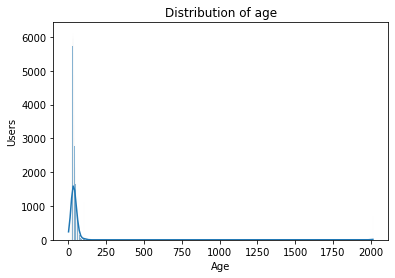

In [ ]:
sns.histplot(train_data['age'],kde=True)
plt.xlabel("Age")
plt.ylabel("Users")
plt.title("Distribution of age")

Here we could see age going more than 2000. It seems some registered their birth year instead of age.

##Data Cleaning##

In [ ]:
outlier_ages=[]
for i in train_data['age'].unique():
  if i>140:
    outlier_ages.append(i)
print("Outlier Ages:")
print(outlier_ages)

Outlier Ages:
[2014.0, 2013.0, 1949.0, 1931.0, 1932.0, 1928.0, 1936.0, 1933.0, 1935.0, 1925.0, 1952.0, 150.0, 1927.0, 1953.0, 1942.0, 1995.0, 2008.0, 1924.0, 1929.0, 1947.0, 1938.0, 1926.0]


For age age between 1900 to 2010 we can find the orginal age by deducting with the year they created the account. For age greater than 2010 we make it as null value and fill it with median age value.

In [ ]:
for i in range(len(train_data['age'])):
  if train_data['age'][i]>150 and train_data['age'][i]<2010:
    train_data['age'][i]=train_data['year_account_created'][i]-train_data['age'][i]

Let us see maximum percentile value

In [ ]:
for i in np.arange(0,101,25):
  print('{} percentile value: {}'.format(i,np.percentile(train_data['age'].dropna(),i)))

0 percentile value: 1.0
25 percentile value: 28.0
50 percentile value: 34.0
75 percentile value: 43.0
100 percentile value: 2014.0


In [ ]:
for i in np.arange(75,101,5):
  print('{} percentile value: {}'.format(i,np.percentile(train_data['age'].dropna(),i)))

75 percentile value: 43.0
80 percentile value: 46.0
85 percentile value: 50.0
90 percentile value: 56.0
95 percentile value: 64.0
100 percentile value: 2014.0


In [ ]:
for i in np.arange(90,101,1):
  print('{} percentile value: {}'.format(i,np.percentile(train_data['age'].dropna(),i)))

90 percentile value: 56.0
91 percentile value: 57.0
92 percentile value: 58.0
93 percentile value: 60.0
94 percentile value: 62.0
95 percentile value: 64.0
96 percentile value: 67.0
97 percentile value: 71.0
98 percentile value: 91.0
99 percentile value: 105.0
100 percentile value: 2014.0


In [ ]:
for i in np.arange(99,100,0.1):
  print('{} percentile value: {}'.format(i,np.percentile(train_data['age'].dropna(),i)))

99.0 percentile value: 105.0
99.1 percentile value: 105.0
99.19999999999999 percentile value: 108.0
99.29999999999998 percentile value: 110.0
99.39999999999998 percentile value: 115.0
99.49999999999997 percentile value: 2014.0
99.59999999999997 percentile value: 2014.0
99.69999999999996 percentile value: 2014.0
99.79999999999995 percentile value: 2014.0
99.89999999999995 percentile value: 2014.0


We could see that 99.39 percentile of age value lie within age 115. Age above that can be converted to 115.

Let us see minimum percentile value

In [ ]:
for i in np.arange(0,26,5):
  print('{} percentile value: {}'.format(i,np.percentile(train_data['age'].dropna(),i)))

0 percentile value: 1.0
5 percentile value: 23.0
10 percentile value: 25.0
15 percentile value: 26.0
20 percentile value: 27.0
25 percentile value: 28.0


In [ ]:
for i in np.arange(0,10,1):
  print('{} percentile value: {}'.format(i,np.percentile(train_data['age'].dropna(),i)))

0 percentile value: 1.0
1 percentile value: 19.0
2 percentile value: 21.0
3 percentile value: 22.0
4 percentile value: 22.0
5 percentile value: 23.0
6 percentile value: 23.0
7 percentile value: 24.0
8 percentile value: 24.0
9 percentile value: 25.0


In [ ]:
for i in np.arange(0,1,0.1):
  print('{} percentile value: {}'.format(i,np.percentile(train_data['age'].dropna(),i)))

0.0 percentile value: 1.0
0.1 percentile value: 17.0
0.2 percentile value: 18.0
0.30000000000000004 percentile value: 18.0
0.4 percentile value: 18.0
0.5 percentile value: 18.0
0.6000000000000001 percentile value: 18.0
0.7000000000000001 percentile value: 19.0
0.8 percentile value: 19.0
0.9 percentile value: 19.0


In [ ]:
for i in np.arange(0,0.11,0.01):
  print('{} percentile value: {}'.format(i,np.percentile(train_data['age'].dropna(),i)))

0.0 percentile value: 1.0
0.01 percentile value: 5.0
0.02 percentile value: 5.0
0.03 percentile value: 5.0
0.04 percentile value: 5.0
0.05 percentile value: 15.0
0.06 percentile value: 16.0
0.07 percentile value: 16.0
0.08 percentile value: 17.0
0.09 percentile value: 17.0
0.1 percentile value: 17.0


We can see that 0.04 percentile of value is less than or equal to 5. We will convert age less that or equal to 5 as 15.

In [ ]:
train_data.age=train_data.age.apply(lambda x: 115 if x>115 else x)
train_data.age=train_data.age.apply(lambda x: 15 if x<15 else x)

In [ ]:
for i in np.arange(0,101,10):
  print('{} percentile value: {}'.format(i,np.percentile(train_data['age'].dropna(),i)))

0 percentile value: 15.0
10 percentile value: 25.0
20 percentile value: 27.0
30 percentile value: 29.0
40 percentile value: 32.0
50 percentile value: 34.0
60 percentile value: 36.0
70 percentile value: 40.0
80 percentile value: 46.0
90 percentile value: 56.0
100 percentile value: 115.0


Let us plot the distribution of age data with respect to country destination.

Text(0.5, 1.0, 'Distribution of age')

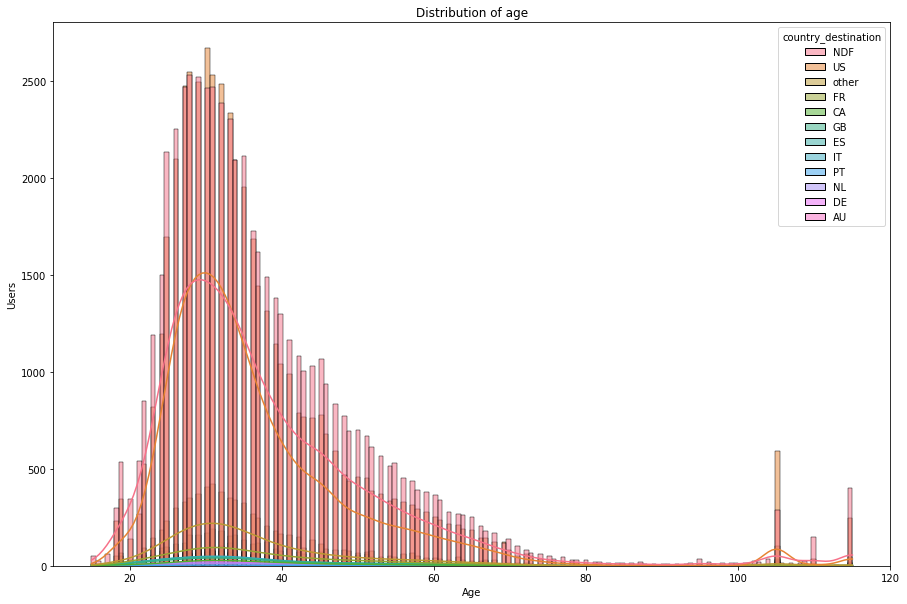

In [ ]:
fig=plt.figure(figsize=(15,10))
sns.histplot(data=train_data,x=train_data['age'],kde=True,hue='country_destination')
plt.xlabel("Age")
plt.ylabel("Users")
plt.title("Distribution of age")

From the above plot we can see that a lot of people between 32 to 34 prefer US destination while NDF remains a bit lower to such category people.

From here we are going to keep track of Nan values a user data have. 'no_of_nans' is the feature which keep tracks of how many nan values does a user have. 

In [ ]:
train_data['no_of_nans']=0
train_data['no_of_nans']

0         0
1         0
2         0
3         0
4         0
         ..
213446    0
213447    0
213448    0
213449    0
213450    0
Name: no_of_nans, Length: 213451, dtype: int64

Let us add +1 in 'no_of_nans' for those users who have nan value in their age column.

In [ ]:
for i in range(len(train_data)):
  if train_data['age'].isna()[i]:
    train_data['no_of_nans'][i]+=1

Since there is a huge datapoints with Nan value for age column we can give a value of -1 for those whose age column is nan.

In [ ]:
train_data.age.fillna(-1,inplace=True)

Let us also create feature age bucket where age is converted to buckets

In [ ]:
def age_to_bucket(val):
  """
  Here we are mapping bucket value to the corresponding age value
  When a value enters the function the age_bucket_dict is looped individually.
  If the value is in the particular array then its corresponding key will be returned.
  Here each key value consist of 5 consecutive age while the last one consist og 6 consecutive age.

  parameter:
    val    : int

  returns:
    key    : string
  """
  age_bucket_dict={'bucket1':np.arange(15,20),'bucket2':np.arange(20,25),
                   'bucket3':np.arange(25,30),'bucket4':np.arange(30,35),
                   'bucket5':np.arange(35,40),'bucket6':np.arange(40,45),
                   'bucket7':np.arange(45,50),'bucket8':np.arange(50,55),
                   'bucket9':np.arange(55,60),'bucket10':np.arange(60,65),
                   'bucket11':np.arange(65,70),'bucket12':np.arange(70,75),
                   'bucket13':np.arange(75,80),'bucket14':np.arange(80,85),
                   'bucket15':np.arange(85,90),'bucket16':np.arange(90,95),
                   'bucket17':np.arange(95,100),'bucket18':np.arange(100,105),
                   'bucket19':np.arange(105,110),'bucket20':np.arange(110,116),
                   'nullbucket': [-1]
                   }
  for key,value in age_bucket_dict.items():
    if val in value:
      return key

In [ ]:
train_data['age_bucket']=train_data['age'].apply(age_to_bucket)

In [ ]:
train_data

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,year_account_created,month_account_created,day_account_created,year_first_active,month_first_active,day_first_active,hour_first_active,no_of_nans,age_bucket
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaN,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2010,6,0,2009,3,3,4,1,nullbucket
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2011,5,2,2009,5,5,17,0,bucket5
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2010,9,1,2009,6,1,23,0,bucket9
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2011,12,0,2009,10,5,6,0,bucket6
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2010,9,1,2009,12,1,6,0,bucket6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-06-30 23:56:36,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,2014,6,0,2014,6,0,23,0,bucket4
213447,mhewnxesx9,2014-06-30,2014-06-30 23:57:19,NaN,-unknown-,-1.0,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,2014,6,0,2014,6,0,23,1,nullbucket
213448,6o3arsjbb4,2014-06-30,2014-06-30 23:57:54,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,2014,6,0,2014,6,0,23,0,bucket4
213449,jh95kwisub,2014-06-30,2014-06-30 23:58:22,NaN,-unknown-,-1.0,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF,2014,6,0,2014,6,0,23,1,nullbucket


Let us again visualise the age dataset.

Text(0.5, 1.0, 'Distribution of age')

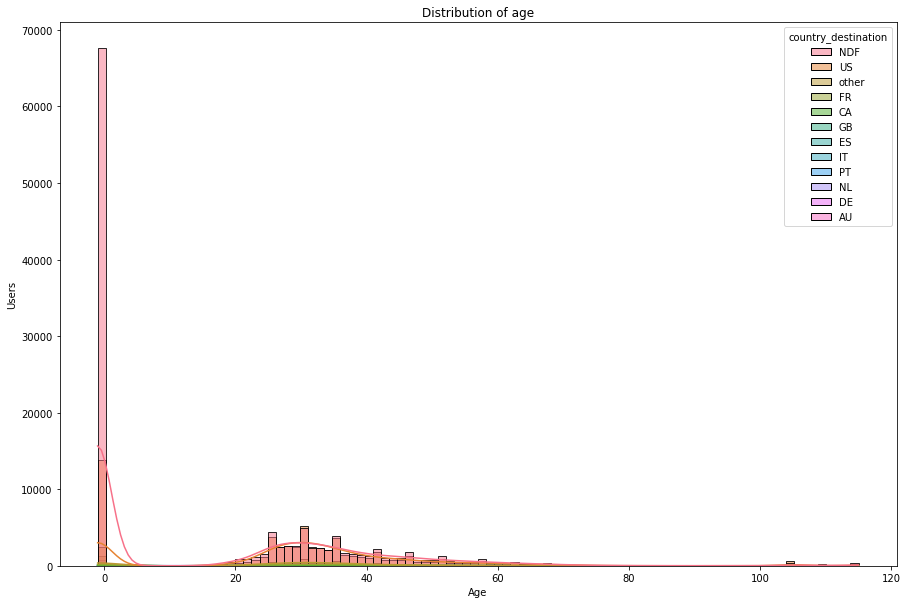

In [ ]:
fig=plt.figure(figsize=(15,10))
sns.histplot(data=train_data,x=train_data['age'],kde=True,hue='country_destination')
plt.xlabel("Age")
plt.ylabel("Users")
plt.title("Distribution of age")

We can see that lot of people who didn't enter their age did'nt do any bookings. This feature could tell us a lot about one's preference in choosing destination.

#Signup flow#

Text(0, 0.5, 'Number of users')

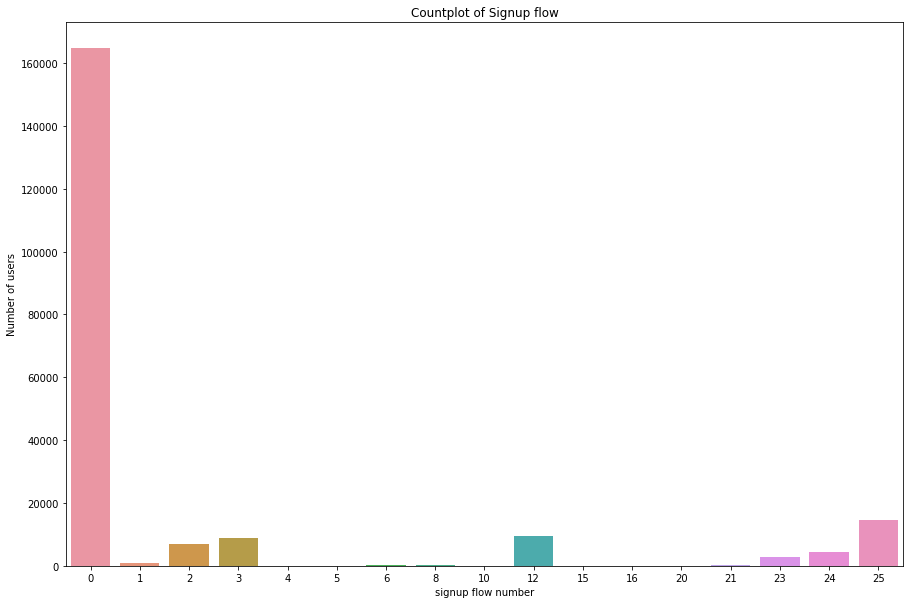

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(data=train_data,x='signup_flow')
plt.title("Countplot of Signup flow")
plt.xlabel("signup flow number")
plt.ylabel("Number of users")

Here we can see that many people signed up to the site from page 0(for security reasons airbnb didn't provide the signup page site). We can also see some cosiderable amount of people signing up from page 25,12,3,2,24,23,1. From other pages it is very low.

#Gender#

Text(0.5, 1.0, 'Number of Users in gender')

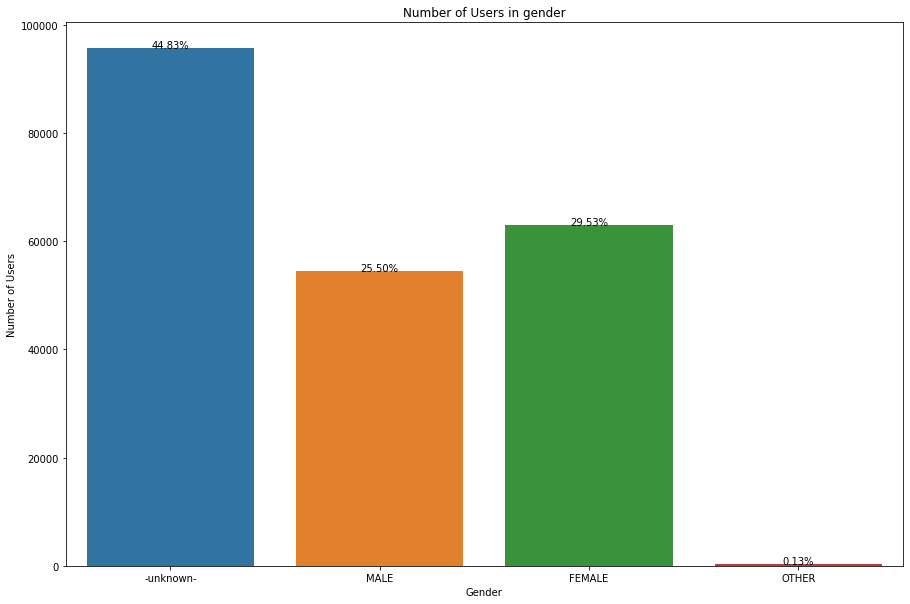

In [ ]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=train_data,x='gender')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.title("Number of Users in gender")

From the above graph we can see feamale users are higher than the male users (according to those who registered their gender).

Text(0.5, 1.0, 'Country preferences based on gender')

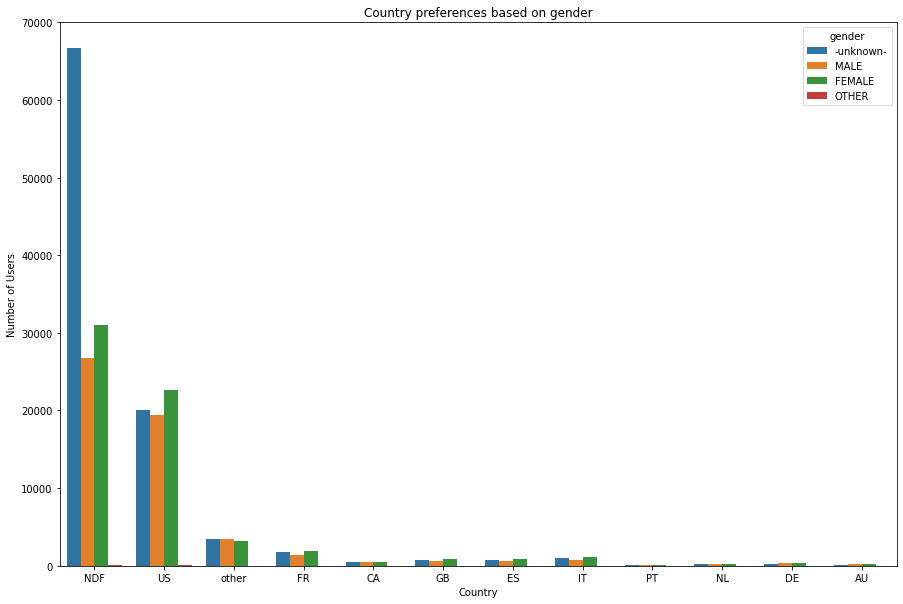

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(data=train_data,hue='gender',x='country_destination')
plt.xlabel("Country")
plt.ylabel("Number of Users")
plt.title("Country preferences based on gender")

From the above chart we can see that many female users prefer US as their destination, while many of those who didn't enter their gender didn't do any booking.

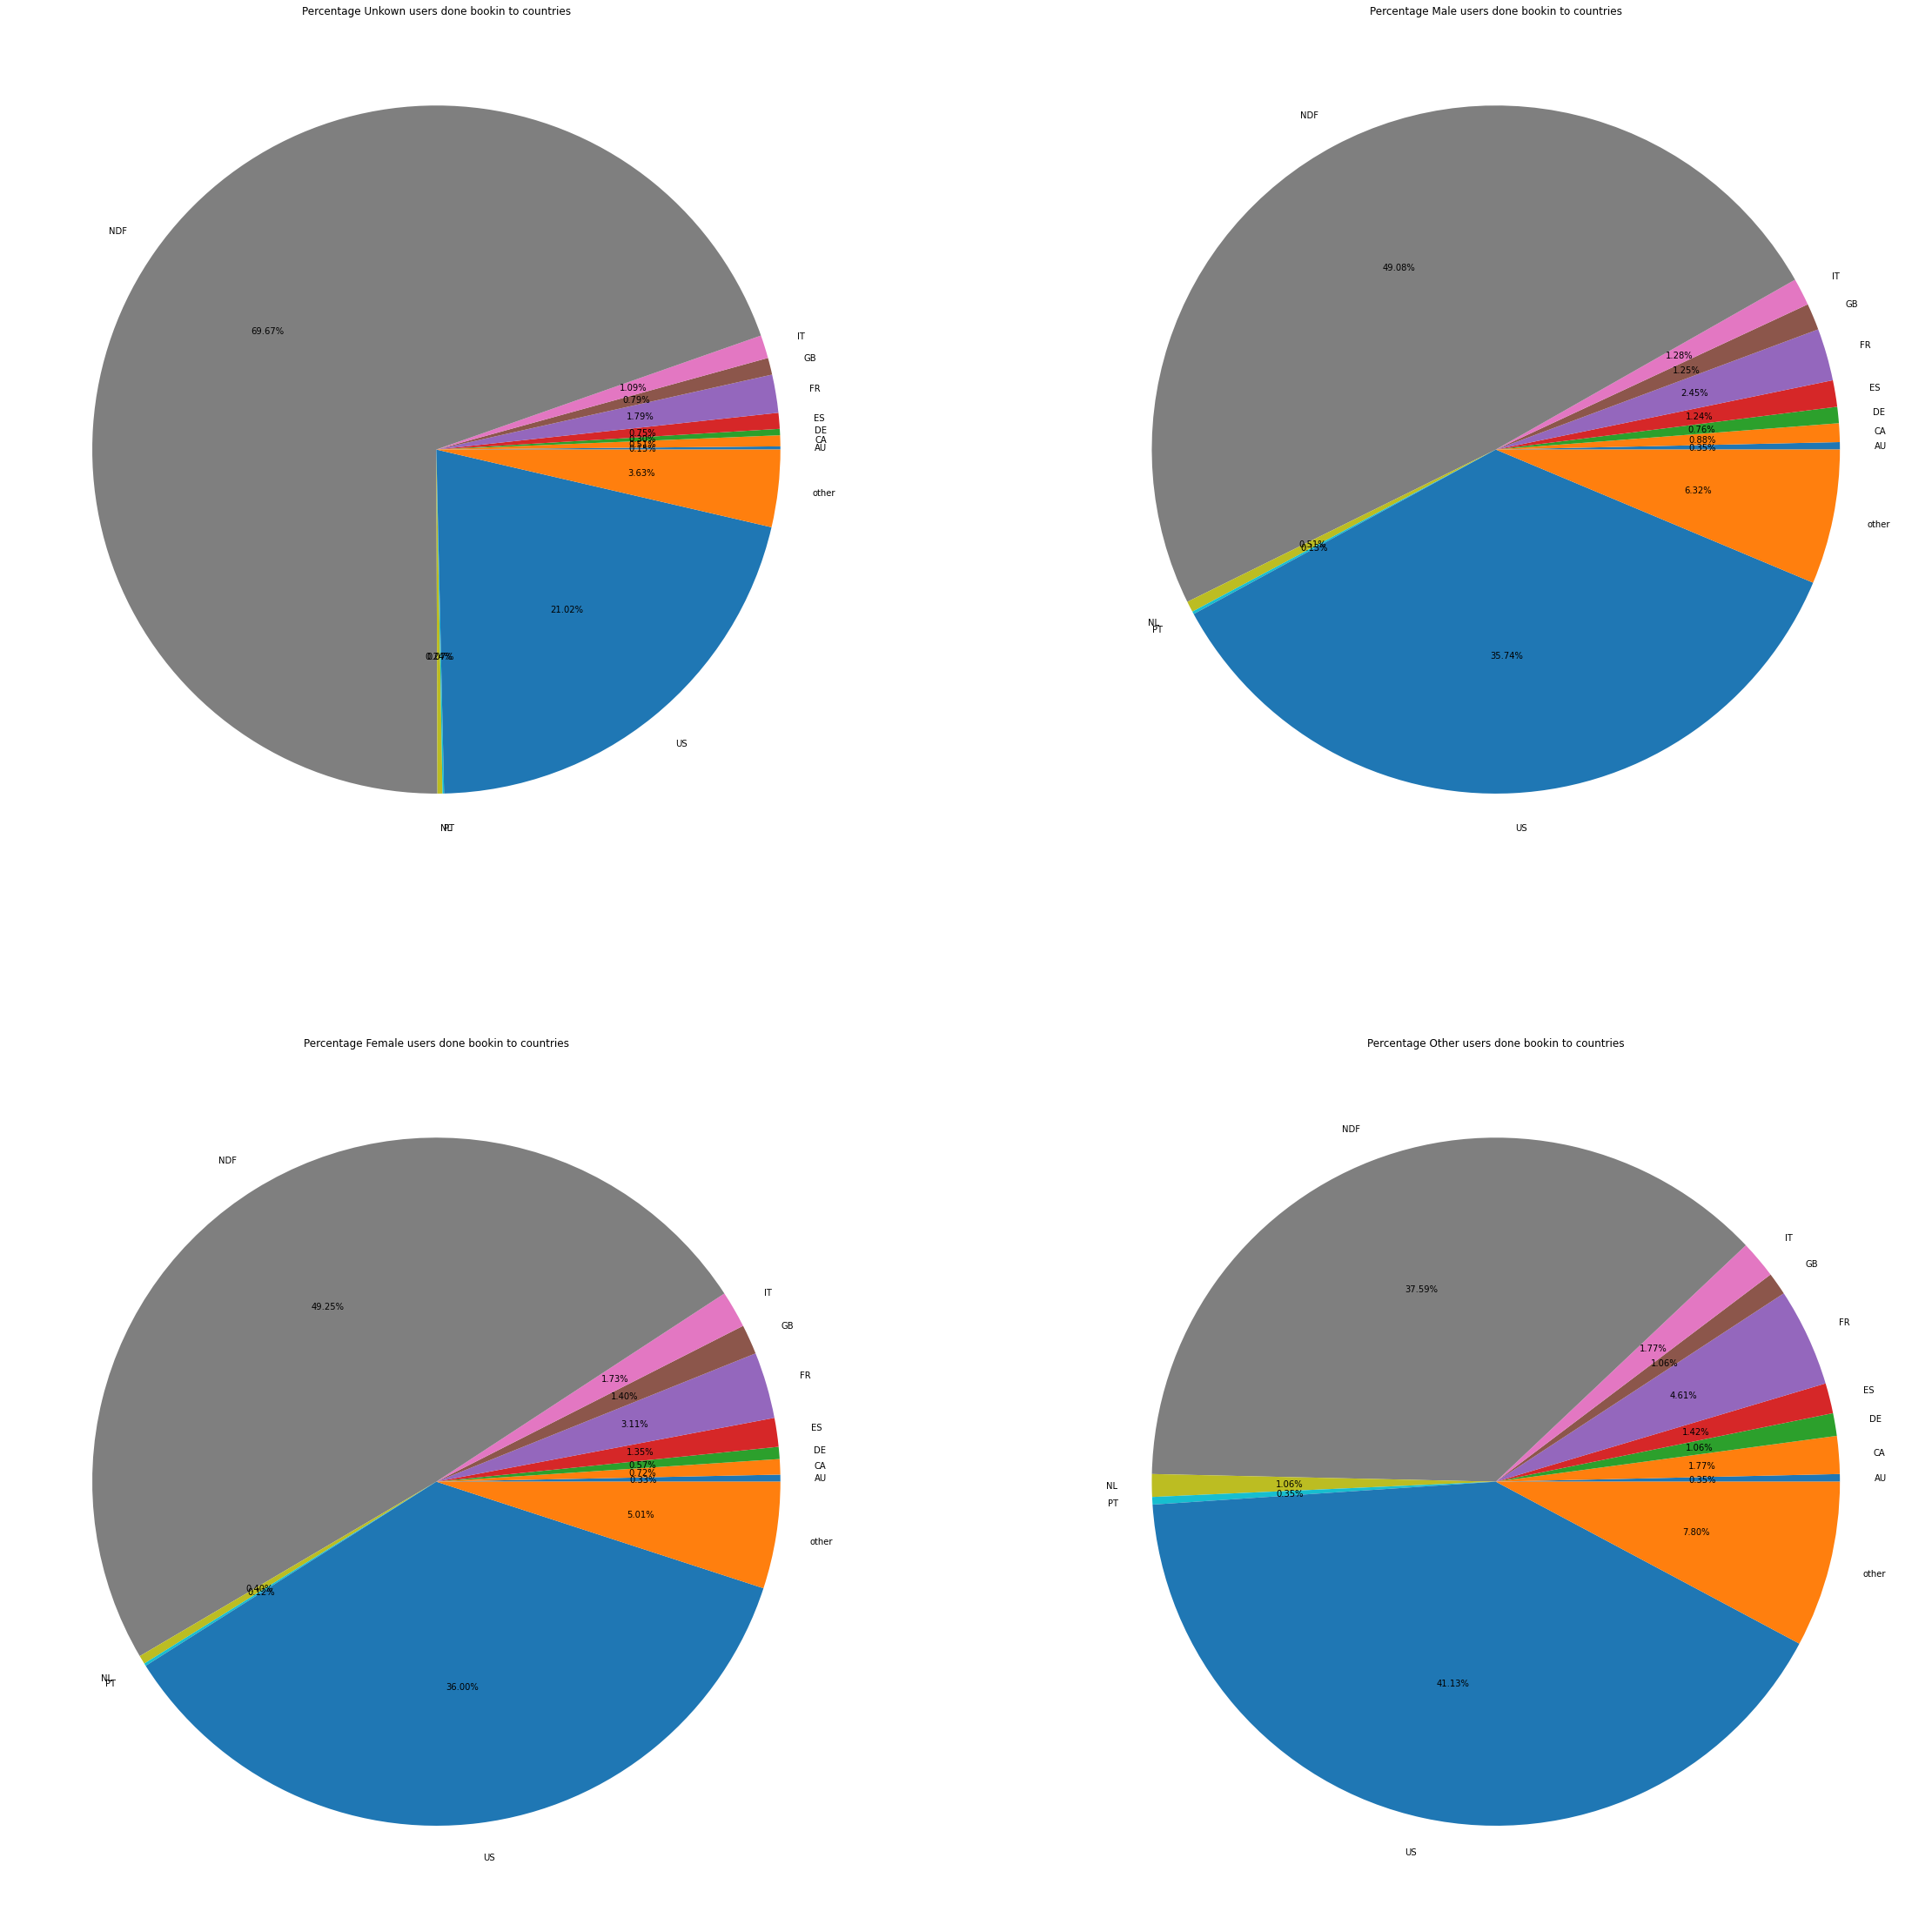

In [ ]:
data_unk=train_data[train_data['gender']=='-unknown-']['country_destination'].value_counts().sort_index()
data_male=train_data[train_data['gender']=='MALE']['country_destination'].value_counts().sort_index()
data_female=train_data[train_data['gender']=='FEMALE']['country_destination'].value_counts().sort_index()
data_other=train_data[train_data['gender']=='OTHER']['country_destination'].value_counts().sort_index()

data=[data_unk,data_male,data_female,data_other]
genders=['Unkown','Male','Female','Other']

fig,ax=plt.subplots(2,2,figsize=(20,20))
fig.set_figheight(40)
fig.set_figwidth(40)
k=0
for i in range(ax.shape[0]):
  for j in range(ax.shape[0]):
    ax[i,j].pie(data[k].values,labels=data[k].index,autopct='%1.2f%%')
    ax[i,j].set_title("Percentage {} users done bookin to countries".format(genders[k]))
    k+=1

From the above graph we can see females prefer US,FR,GB,ES,IT than males. Also we can see that people who didn't enter thier gender(ie unknown) mostly fall under NDF wherelse a person who prefers to a country destination mostly enters gender details. This feature helps us a lot in segregating users who prefer a country destination to the ones who don't prefer.

Here we consider unknown gender as a nan value and give a plus one in 'no_on_nans' feature for those users who have not entered their gender.

In [ ]:
for i in range(len(train_data)):
  if train_data['gender'][i]=='-unknown-':
    train_data['no_of_nans'][i]+=1

In [ ]:
len(train_data[train_data['gender']=='-unknown-'])

95688

In [ ]:
train_data['no_of_nans'].values.sum()

183678

#Signup Method#

Text(0.5, 1.0, 'Number of users based on their sign up method')

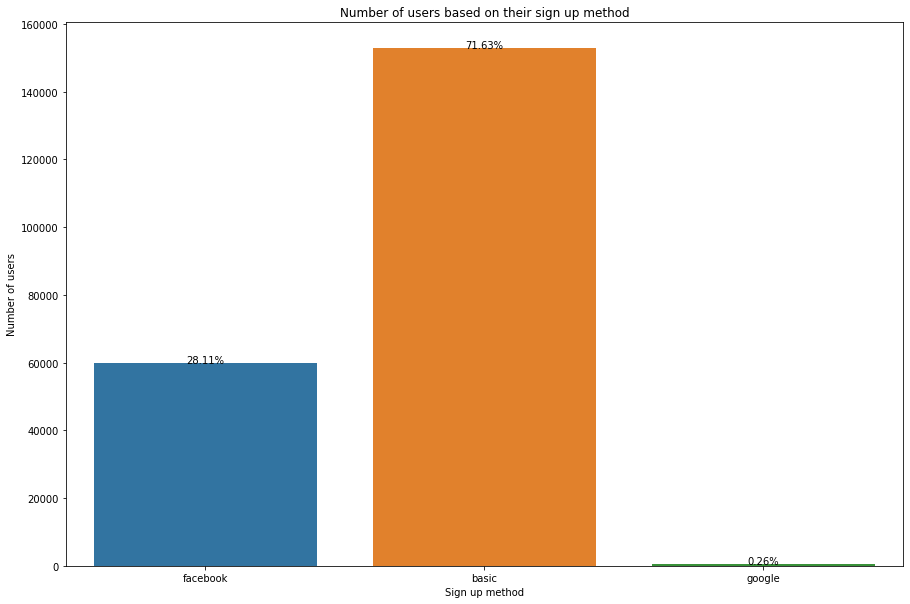

In [ ]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=train_data,x='signup_method')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.xlabel("Sign up method")
plt.ylabel("Number of users")
plt.title("Number of users based on their sign up method")

We can see that about 71.63% of users did basic sign up while 28.11% used their facebook credenitals to sign up and 0.26% used their google accounts. 

Text(0.5, 1.0, 'Country preferences based on sign up method')

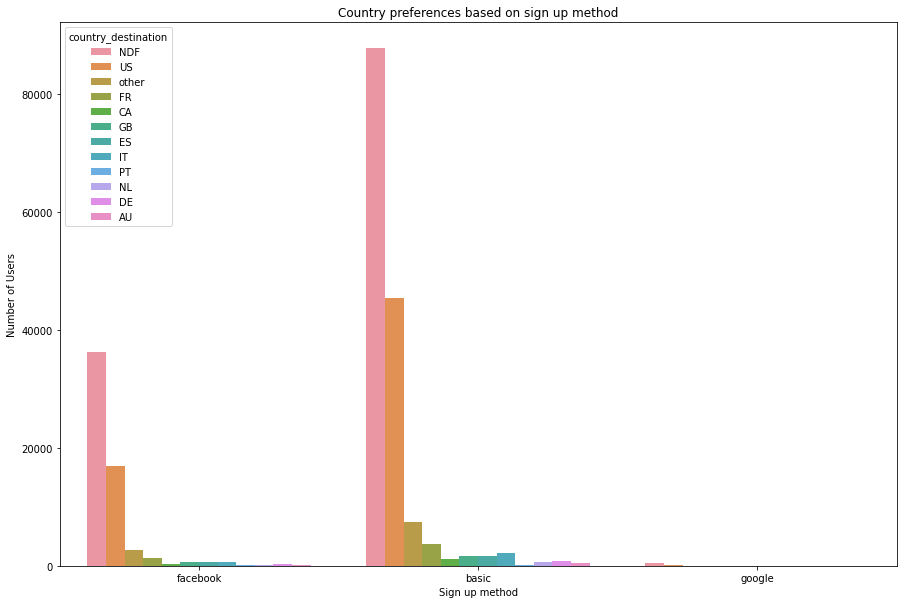

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(data=train_data,x='signup_method',hue='country_destination')
plt.xlabel("Sign up method")
plt.ylabel("Number of Users")
plt.title("Country preferences based on sign up method")

The above graph shows that all three sign up method almost follows same trend when it comes to users preferences. Let us check in depth with pie diagram.

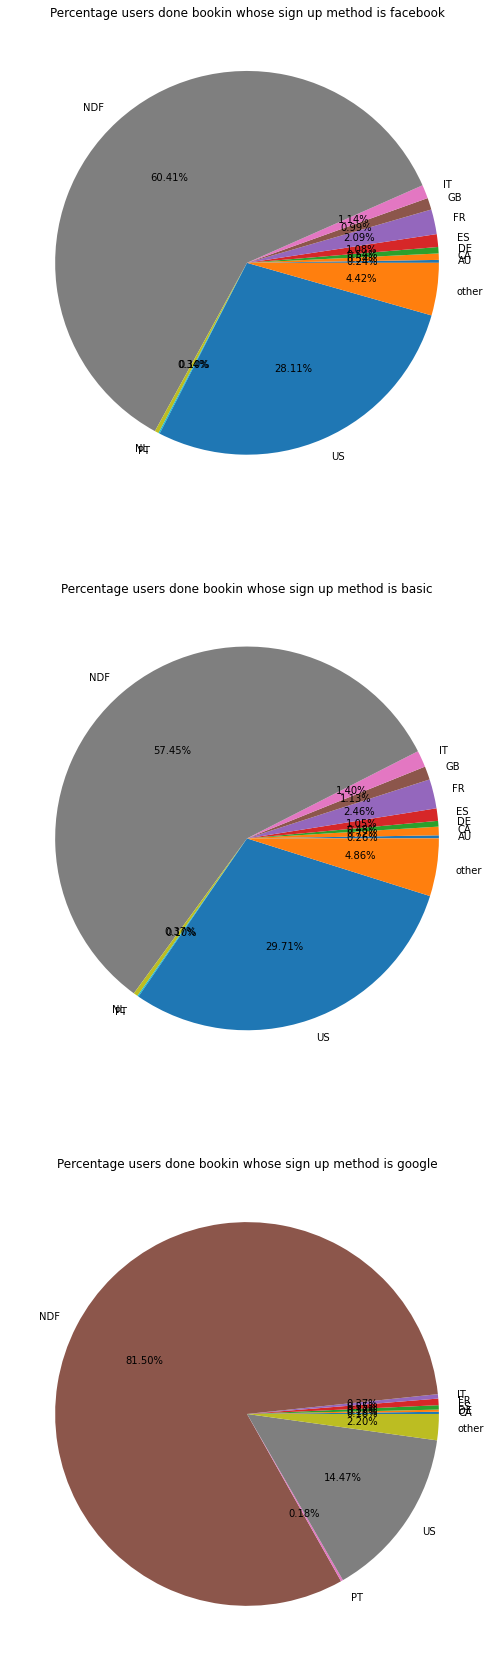

In [ ]:
data_fb=train_data[train_data['signup_method']=='facebook']['country_destination'].value_counts().sort_index()
data_basic=train_data[train_data['signup_method']=='basic']['country_destination'].value_counts().sort_index()
data_google=train_data[train_data['signup_method']=='google']['country_destination'].value_counts().sort_index()
data=[data_fb,data_basic,data_google]
signup_met=['facebook','basic','google']

fig,ax=plt.subplots(3,figsize=(20,20))
fig.set_figheight(30)
fig.set_figwidth(30)
for i in range(ax.shape[0]):
  ax[i].pie(data[i].values,labels=data[i].index,autopct='%1.2f%%')
  ax[i].set_title("Percentage users done bookin whose sign up method is {}".format(signup_met[i]))

From the above pie diagram we can see that a persons who are doing sign up on using google account doesn't prefer destination. This is because we have very few data on the users who used their google account to sign up. Other than this we can find similar trend in both the users who did their signup through basic method and using facebook credentials

#Language#

Text(0.5, 1.0, 'Countplot of users based on the language they know')

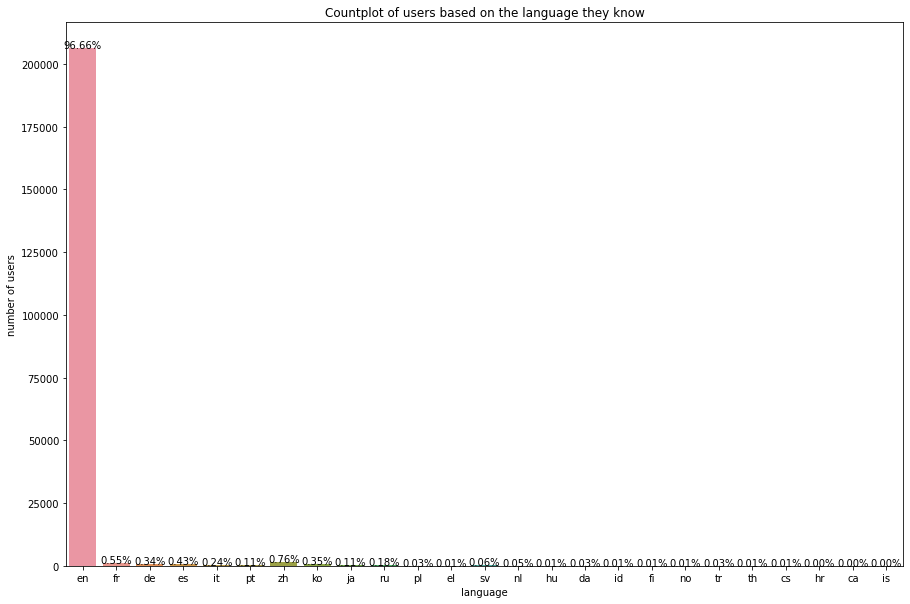

In [ ]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=train_data,x='language')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.xlabel('language')
plt.ylabel('number of users')
plt.title("Countplot of users based on the language they know")

We can see that 96.66% of people native language is english and the rest lie below 1%. Let us convert languages less than 0.01% to 'Other' language. We are doing this beacuse when modelling we need to convert each language into feature and this may consume a lot of memory and also this is not of much useful for prediction.

In [ ]:
selected_language=(100*train_data['language'].value_counts()/train_data.shape[0]).index[:10]
selected_language

Index(['en', 'zh', 'fr', 'es', 'ko', 'de', 'it', 'ru', 'pt', 'ja'], dtype='object')

These ten language have presence more than 0.1%. Apart from these other languages are changed as 'Other' string.

In [ ]:
train_data.language=train_data.language.apply(lambda x: 'Other' if x not in selected_language else x)

In [ ]:
train_data['language'].value_counts()

en       206314
zh         1632
fr         1172
es          915
ko          747
de          732
Other       571
it          514
ru          389
pt          240
ja          225
Name: language, dtype: int64

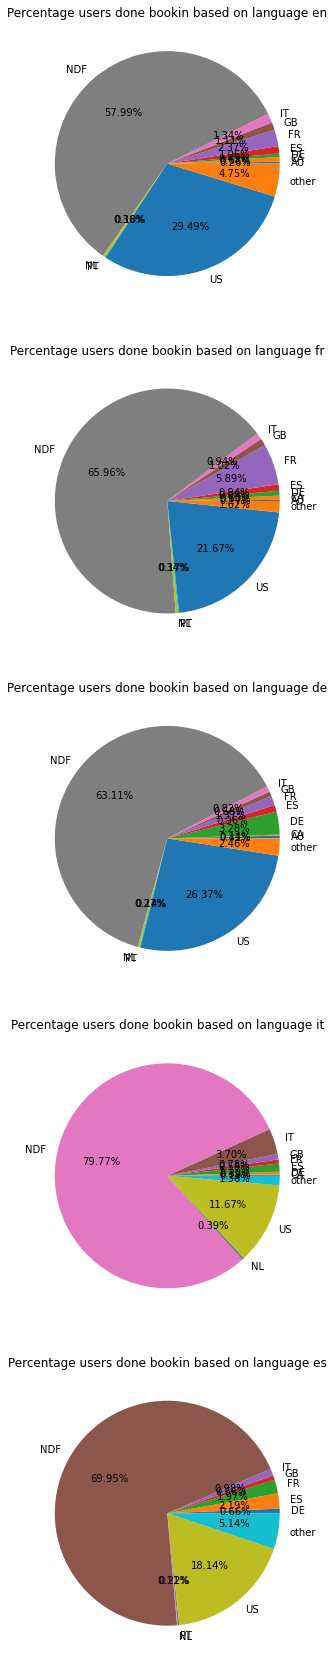

In [ ]:
#data_en contains user counts of each country destination where user's language is english.
#Similarly done for other languages.

data_en=train_data[train_data['language']=='en']['country_destination'].value_counts().sort_index()
data_fr=train_data[train_data['language']=='fr']['country_destination'].value_counts().sort_index()
data_de=train_data[train_data['language']=='de']['country_destination'].value_counts().sort_index()
data_it=train_data[train_data['language']=='it']['country_destination'].value_counts().sort_index()
data_es=train_data[train_data['language']=='es']['country_destination'].value_counts().sort_index()
data=[data_en,data_fr,data_de,data_it,data_es]
language=['en','fr','de','it','es']

fig,ax=plt.subplots(5,figsize=(20,20))
fig.set_figheight(30)
fig.set_figwidth(30)
for i in range(ax.shape[0]):
  ax[i].pie(data[i].values,labels=data[i].index,autopct='%1.2f%%')
  ax[i].set_title("Percentage users done bookin based on language {}".format(language[i]))

From the above graph we can see an slight increase in the percentage of the native language speaker to their respective language country. That is french speaking users have a slight increase in country destination of going to france.

#Affiliate_channel#

Text(0.5, 1.0, 'Number of users based on affliate channel')

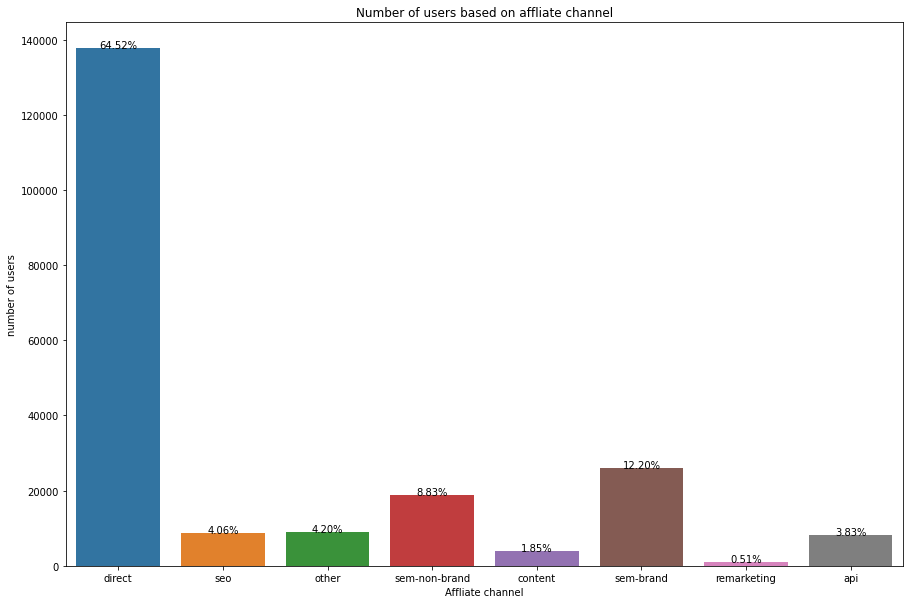

In [ ]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=train_data,x='affiliate_channel')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.xlabel("Affliate channel")
plt.ylabel("number of users")
plt.title("Number of users based on affliate channel")

We can see that direct type of advertisment(or marketting) has attracted 64.52% of people to this site, while other paid marketting contents like seo, content have attracted much lower impact on attracting users. 

Let us check how the type of marketting that attracted the user impacts people's decision.

Text(0.5, 1.0, 'Number of users based on affliate channel')

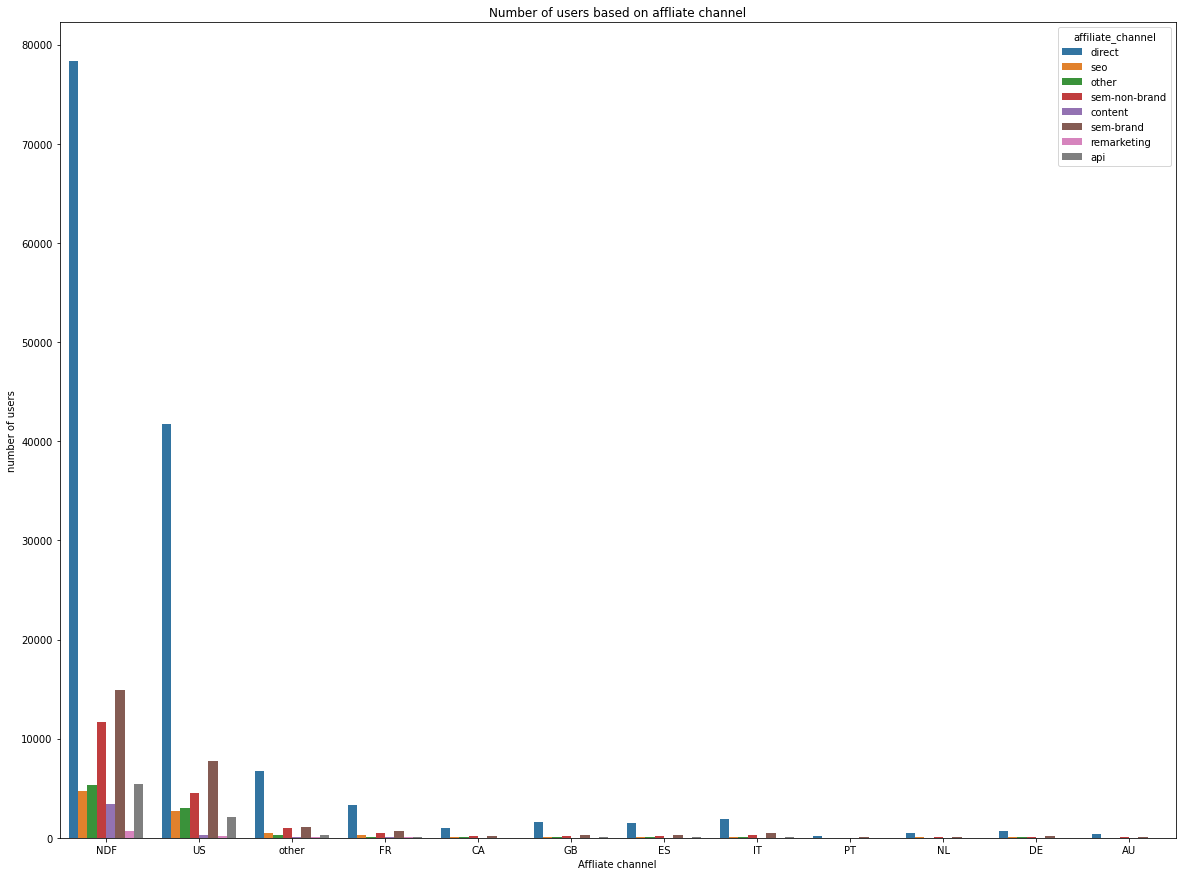

In [ ]:
plt.figure(figsize=(20,15))
ax=sns.countplot(data=train_data,hue='affiliate_channel',x='country_destination')
plt.xlabel("Affliate channel")
plt.ylabel("number of users")
plt.title("Number of users based on affliate channel")

In the above chart we can see that a user who came to the site by a content affiliate mostly chooses no destinations. We can see that in US for the users who come through content is significantly low than that of comparing with NDF. 

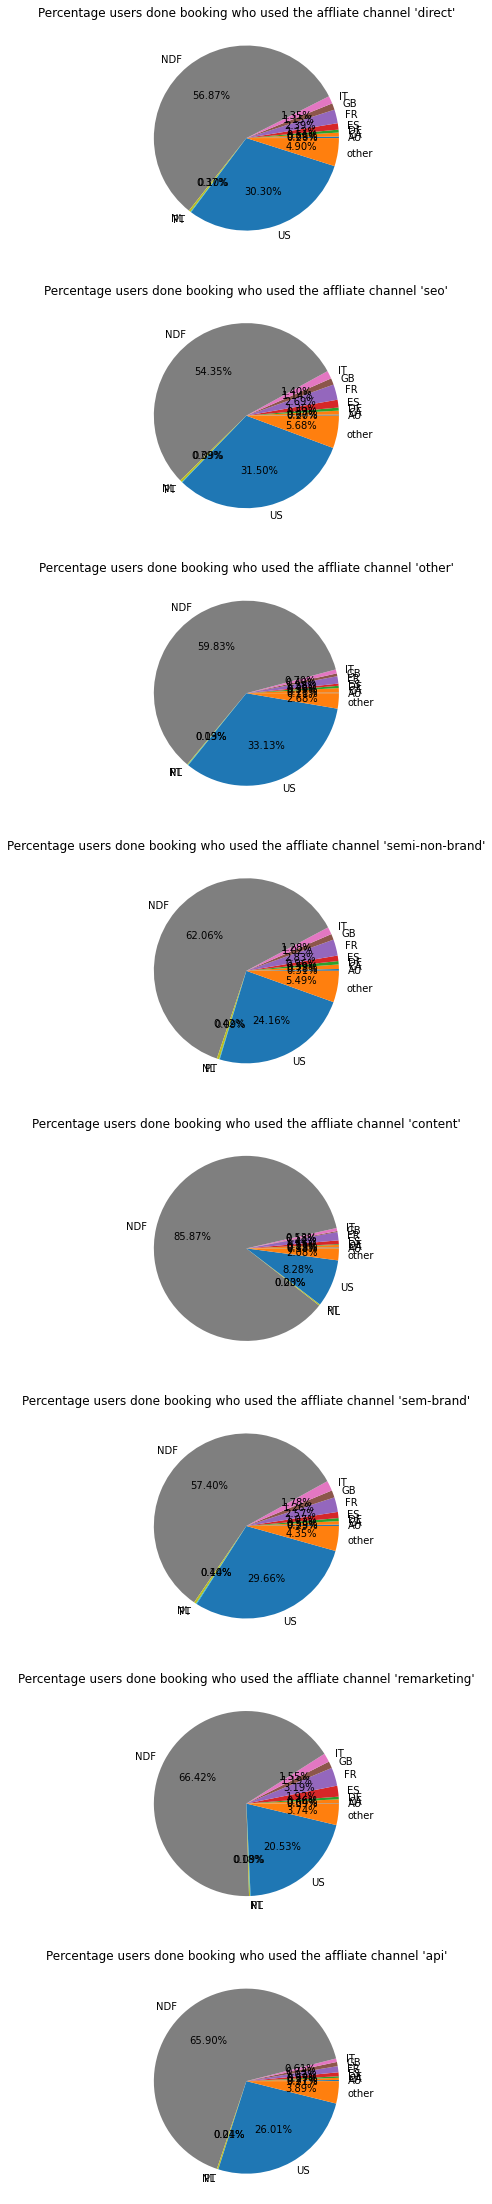

In [ ]:
#Here data_di have the number of bookings done by the users to each country who arrived through direct type of marketting
#Similarly all other affliate channels are considered

data_di=train_data[train_data['affiliate_channel']=='direct']['country_destination'].value_counts().sort_index()
data_seo=train_data[train_data['affiliate_channel']=='seo']['country_destination'].value_counts().sort_index()
data_ot=train_data[train_data['affiliate_channel']=='other']['country_destination'].value_counts().sort_index()
data_snb=train_data[train_data['affiliate_channel']=='sem-non-brand']['country_destination'].value_counts().sort_index()
data_co=train_data[train_data['affiliate_channel']=='content']['country_destination'].value_counts().sort_index()
data_sb=train_data[train_data['affiliate_channel']=='sem-brand']['country_destination'].value_counts().sort_index()
data_re=train_data[train_data['affiliate_channel']=='remarketing']['country_destination'].value_counts().sort_index()
data_api=train_data[train_data['affiliate_channel']=='api']['country_destination'].value_counts().sort_index()

data=[data_di,data_seo,data_ot,data_snb,data_co,data_sb,data_re,data_api]
af_channel=['direct','seo','other','semi-non-brand','content','sem-brand','remarketing','api']

fig,ax=plt.subplots(8,figsize=(20,20))
fig.set_figheight(40)
fig.set_figwidth(40)
for i in range(ax.shape[0]):
  ax[i].pie(data[i].values,labels=data[i].index,autopct='%1.2f%%')
  ax[i].set_title("Percentage users done booking who used the affliate channel '{}'".format(af_channel[i]))

From the above chart we can see that the users who are from content based affliate channel doesn't usually make decision because NDF is 85.87%. Also, people who arrived to the site through 'other' types of affliation have the highest percentage of people going to US compared to other affliate channels. 

#affliate Provider#

Text(0.5, 1.0, 'Number of users based on affliate provider')

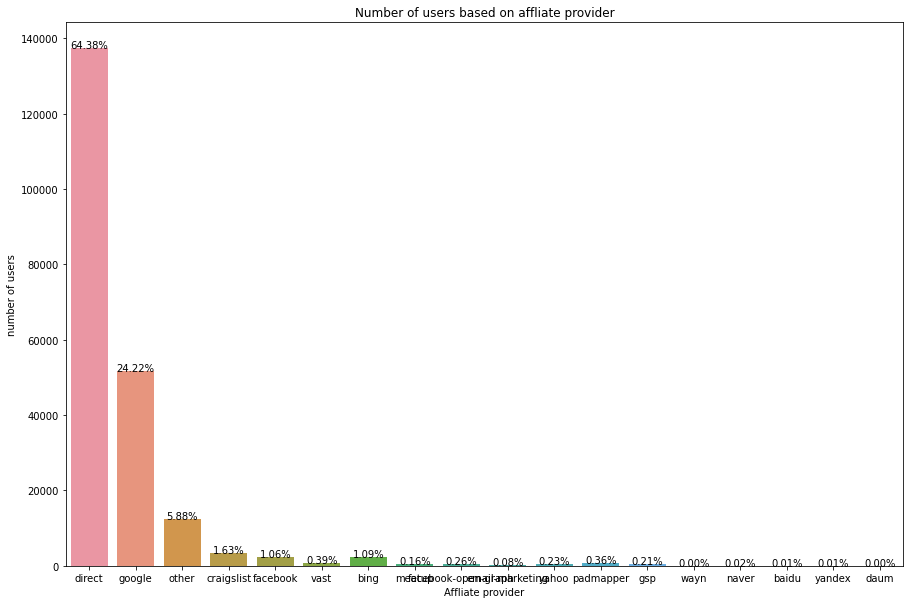

In [ ]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=train_data,x='affiliate_provider')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.xlabel("Affliate provider")
plt.ylabel("number of users")
plt.title("Number of users based on affliate provider")

As we saw before how direct affiliation by the company attracted many users, here we can see that 64.38% users clicked the advertisment provided by the site directly. Other than that google also played a significant role in it making up to 24.22% of users, followed by some other websites like craigslist, facebook and so on.  

Here we can see that there are few providers whose presence is less than 0.1%. So we can change those 'others' for our convenience.

In [ ]:
100*(train_data.affiliate_provider.value_counts()/train_data.shape[0])

direct                 64.382926
google                 24.217736
other                   5.879101
craigslist              1.626134
bing                    1.090648
facebook                1.064881
vast                    0.388380
padmapper               0.359802
facebook-open-graph     0.255328
yahoo                   0.232372
gsp                     0.212227
meetup                  0.162567
email-marketing         0.077770
naver                   0.024362
baidu                   0.013586
yandex                  0.007964
wayn                    0.003748
daum                    0.000468
Name: affiliate_provider, dtype: float64

In [ ]:
selected_aff_provider=(100*(train_data.affiliate_provider.value_counts()/train_data.shape[0]))[:12].index
selected_aff_provider

Index(['direct', 'google', 'other', 'craigslist', 'bing', 'facebook', 'vast',
       'padmapper', 'facebook-open-graph', 'yahoo', 'gsp', 'meetup'],
      dtype='object')

Since we have a category called other let us name the new category(which holds category names that have less occurances) as 'smallcontribution' meaning that they have small contribution.

In [ ]:
train_data.affiliate_provider=train_data.affiliate_provider.apply(lambda x: 'smallcontribution' if x not in selected_aff_provider else x)

In [ ]:
train_data.affiliate_provider.value_counts()

direct                 137426
google                  51693
other                   12549
craigslist               3471
bing                     2328
facebook                 2273
vast                      829
padmapper                 768
facebook-open-graph       545
yahoo                     496
gsp                       453
meetup                    347
smallcontribution         273
Name: affiliate_provider, dtype: int64

Let us find how affliate provider impacts people decision. Here we will analyse top 6 (ie direct,google,other,craigslist,facebook,bing).

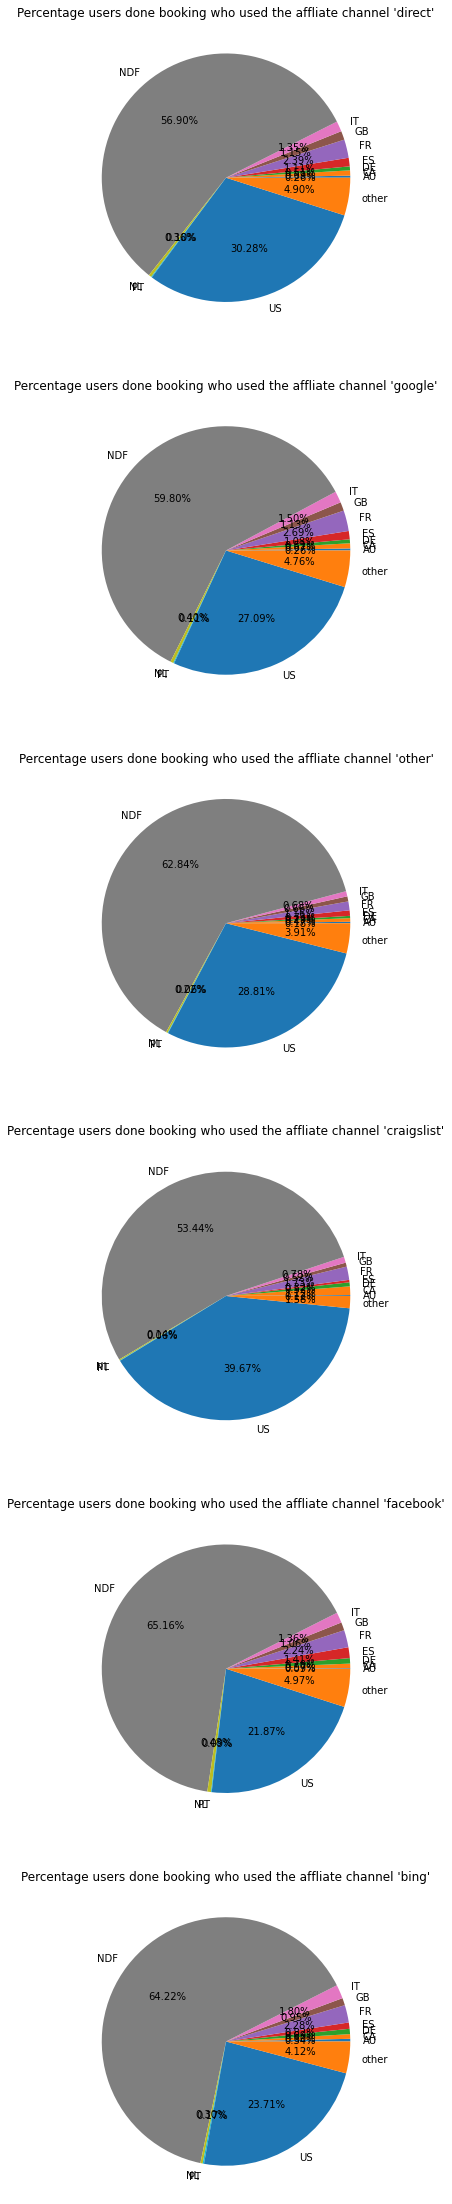

In [ ]:
#Here data_di contains total number of users booked to each destination where the user's affiliate provider is 'direct'
#Similarly for other affiliate providers thi is done.

data_di=train_data[train_data['affiliate_provider']=='direct']['country_destination'].value_counts().sort_index()
data_go=train_data[train_data['affiliate_provider']=='google']['country_destination'].value_counts().sort_index()
data_ot=train_data[train_data['affiliate_provider']=='other']['country_destination'].value_counts().sort_index()
data_cr=train_data[train_data['affiliate_provider']=='craigslist']['country_destination'].value_counts().sort_index()
data_fb=train_data[train_data['affiliate_provider']=='facebook']['country_destination'].value_counts().sort_index()
data_bi=train_data[train_data['affiliate_provider']=='bing']['country_destination'].value_counts().sort_index()

data=[data_di,data_go,data_ot,data_cr,data_fb,data_bi]
af_provider=['direct','google','other','craigslist','facebook','bing']

fig,ax=plt.subplots(6,figsize=(20,20))
fig.set_figheight(40)
fig.set_figwidth(40)
for i in range(ax.shape[0]):
  ax[i].pie(data[i].values,labels=data[i].index,autopct='%1.2f%%')
  ax[i].set_title("Percentage users done booking who used the affliate channel '{}'".format(af_provider[i]))

From the above pie diagram we can see that people who used craigslist has an increased percentage of users who book to US than the others. This feature could help us in our prediction.

#First_tracked_affliate#

In [ ]:
print("Number of missing values:",train_data['first_affiliate_tracked'].isna().sum())

Number of missing values: 6065


In [ ]:
train_data['first_affiliate_tracked'].unique()

array(['untracked', 'omg', nan, 'linked', 'tracked-other', 'product',
       'marketing', 'local ops'], dtype=object)

Text(0.5, 1.0, 'Number of users based on first affliate tracked')

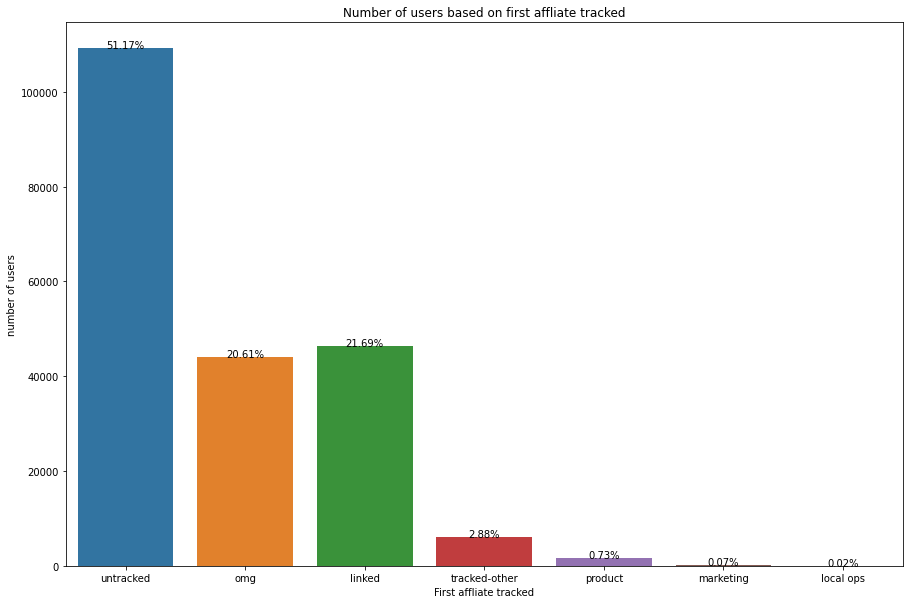

In [ ]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=train_data,x='first_affiliate_tracked')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.xlabel("First affliate tracked")
plt.ylabel("number of users")
plt.title("Number of users based on first affliate tracked")

This field tells us the first recorded advertisment that user used to arrive to this site. About 51.17% are untracked while OMG (an affiliate provider) stands third with 20.61%.

For nan values as we don't know the track path let us fill it as untracked.

In [ ]:
train_data['first_affiliate_tracked'].fillna('untracked',inplace=True)

Here we can see that marketting and local ops shows its presence less than 0.01%. We can combine both as 'others'.

In [ ]:
100*(train_data.first_affiliate_tracked.value_counts()/train_data.shape[0])

untracked        54.015676
linked           21.685071
omg              20.605197
tracked-other     2.884034
product           0.728973
marketing         0.065120
local ops         0.015929
Name: first_affiliate_tracked, dtype: float64

In [ ]:
selected_aff_track=(100*(train_data.first_affiliate_tracked.value_counts()/train_data.shape[0]))[:5].index
selected_aff_track

Index(['untracked', 'linked', 'omg', 'tracked-other', 'product'], dtype='object')

In [ ]:
train_data.first_affiliate_tracked=train_data.first_affiliate_tracked.apply(lambda x: 'others' if x not in selected_aff_track else x)

In [ ]:
train_data.first_affiliate_tracked.value_counts()

untracked        115297
linked            46287
omg               43982
tracked-other      6156
product            1556
others              173
Name: first_affiliate_tracked, dtype: int64

Here untracked is considered as nan value. So we will give additional +1 to the column 'no_of_nans' for those whose first affiliate track is nan.

In [ ]:
for i in range(len(train_data)):
  if train_data['first_affiliate_tracked'][i]=='untracked':
    train_data['no_of_nans'][i]+=1

In [ ]:
train_data['no_of_nans'].values.sum()

298975

#Signup App#

Text(0.5, 1.0, 'Number of users based on thier sign up app')

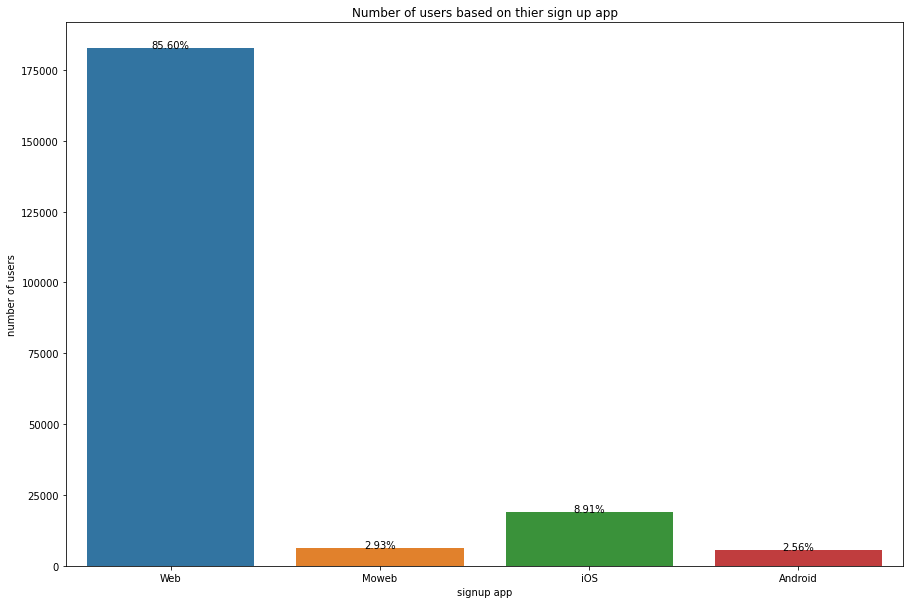

In [ ]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=train_data,x='signup_app')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.xlabel("signup app")
plt.ylabel("number of users")
plt.title("Number of users based on thier sign up app")

We could see that large number of users, around 85.6% of people used Web applications to sign in. Ios application stands second with around 8.9% of users and with mobile web application 2.93% people signed up. 

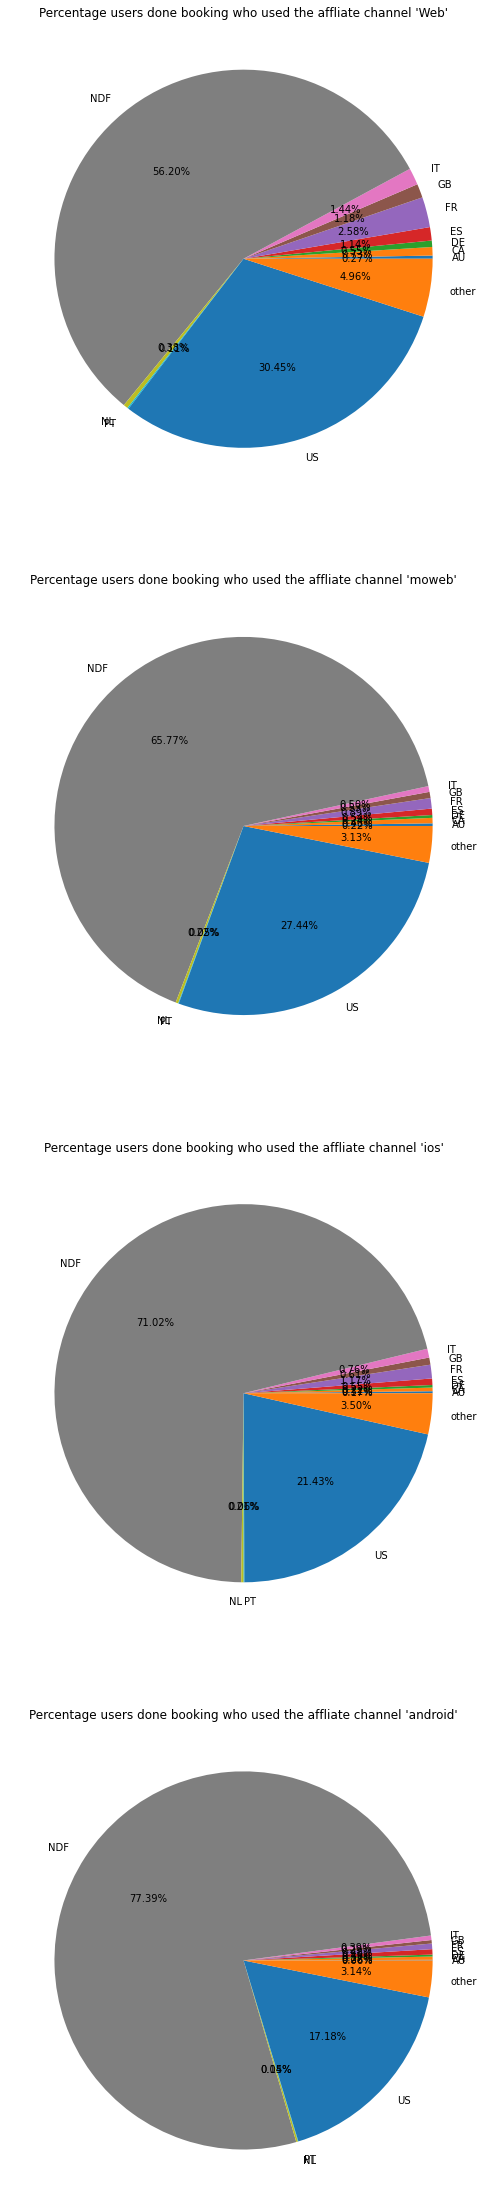

In [ ]:
data_web=train_data[train_data['signup_app']=='Web']['country_destination'].value_counts().sort_index()
data_mweb=train_data[train_data['signup_app']=='Moweb']['country_destination'].value_counts().sort_index()
data_ios=train_data[train_data['signup_app']=='iOS']['country_destination'].value_counts().sort_index()
data_and=train_data[train_data['signup_app']=='Android']['country_destination'].value_counts().sort_index()

data=[data_web,data_mweb,data_ios,data_and]
af_provider=['Web','moweb','ios','android']

fig,ax=plt.subplots(4,figsize=(20,20))
fig.set_figheight(40)
fig.set_figwidth(40)
for i in range(ax.shape[0]):
  ax[i].pie(data[i].values,labels=data[i].index,autopct='%1.2f%%')
  ax[i].set_title("Percentage users done booking who used the affliate channel '{}'".format(af_provider[i]))

We can see that people who use mobile android or ios applications during sign up have considerably more percentage of people who does'nt prefer any destination. 

#First device type#

Text(0.5, 1.0, 'Number of users based on thier first device type')

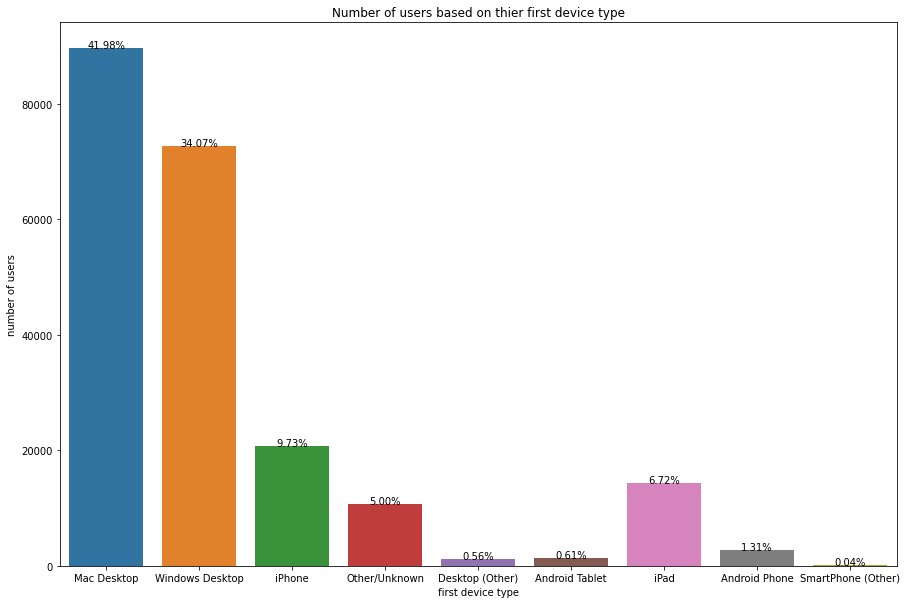

In [ ]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=train_data,x='first_device_type')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.xlabel("first device type")
plt.ylabel("number of users")
plt.title("Number of users based on thier first device type")

As we saw before Web applications are more preferred than mobile web applications, here we could see which kind of desktops, mobile, ipad more used by users. Desktop are used more by the users. When it comes to mobile phone types (including ipad) iphones contribute 9.73% followed by ipad 6.72% of users while android users are 1.31%. Overall we could see apple products lead the table.

Let us see how the device usage helps in finding user's preference.

Text(0.5, 1.0, 'Number of users based on thier first device type')

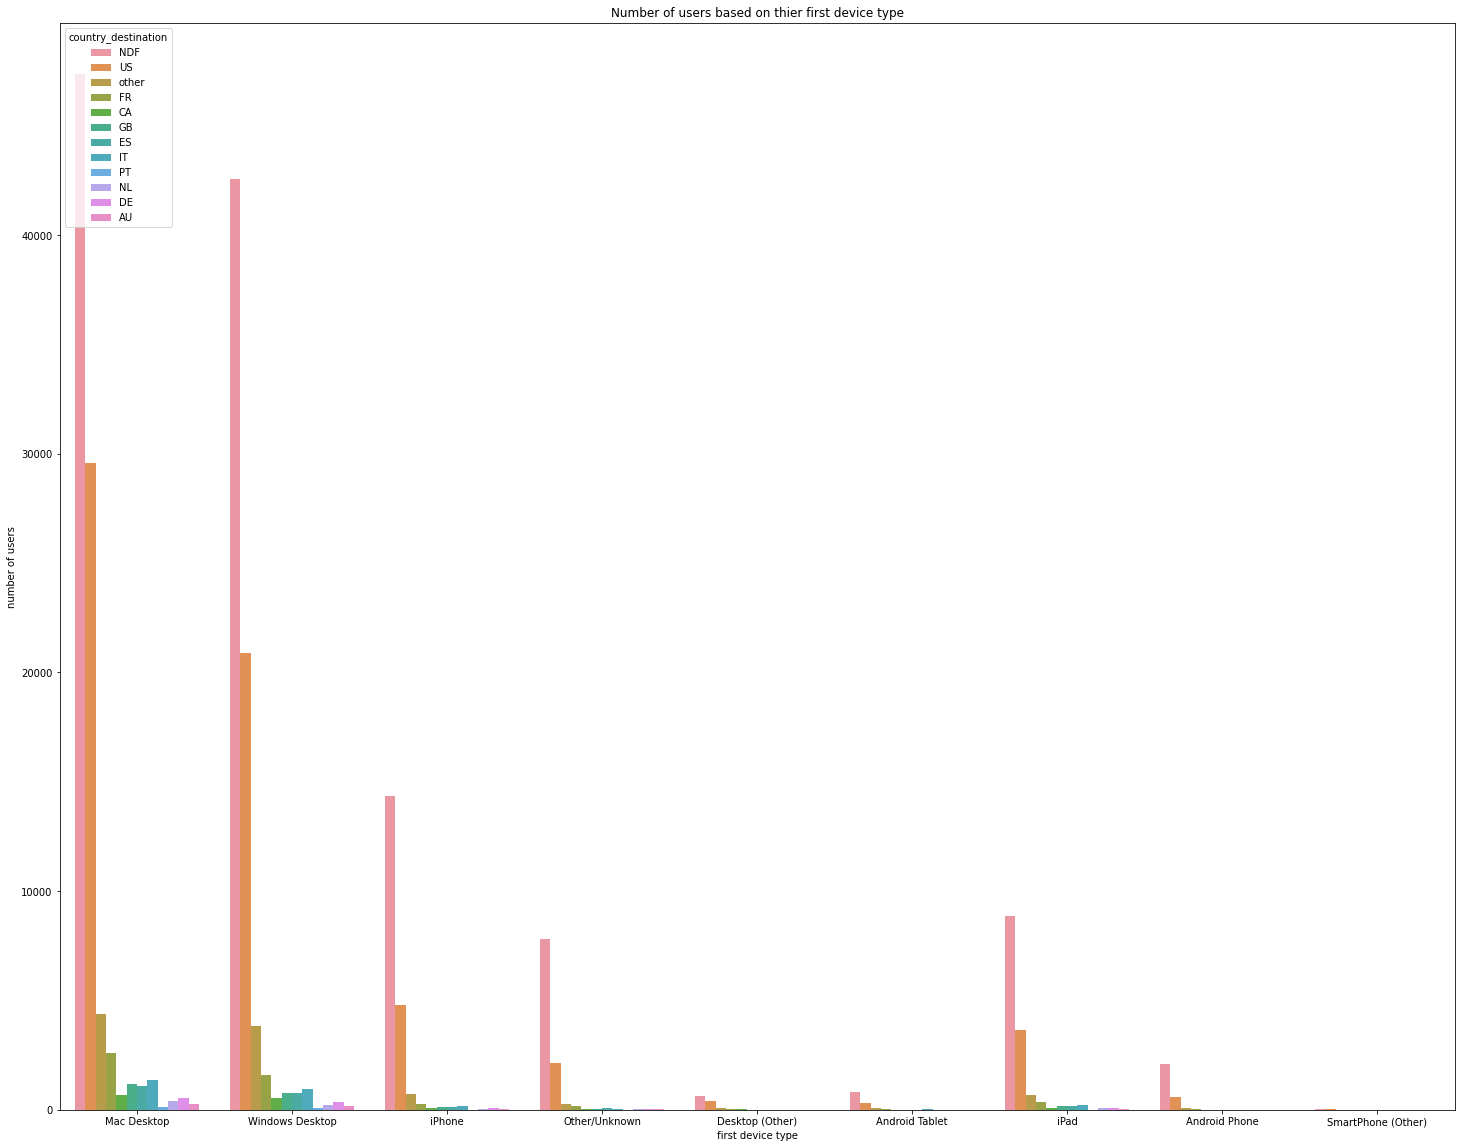

In [ ]:
plt.figure(figsize=(25,20))
ax=sns.countplot(data=train_data,x='first_device_type',hue='country_destination')
plt.xlabel("first device type")
plt.ylabel("number of users")
plt.title("Number of users based on thier first device type")

In [ ]:
train_data.first_device_type.unique()

array(['Mac Desktop', 'Windows Desktop', 'iPhone', 'Other/Unknown',
       'Desktop (Other)', 'Android Tablet', 'iPad', 'Android Phone',
       'SmartPhone (Other)'], dtype=object)

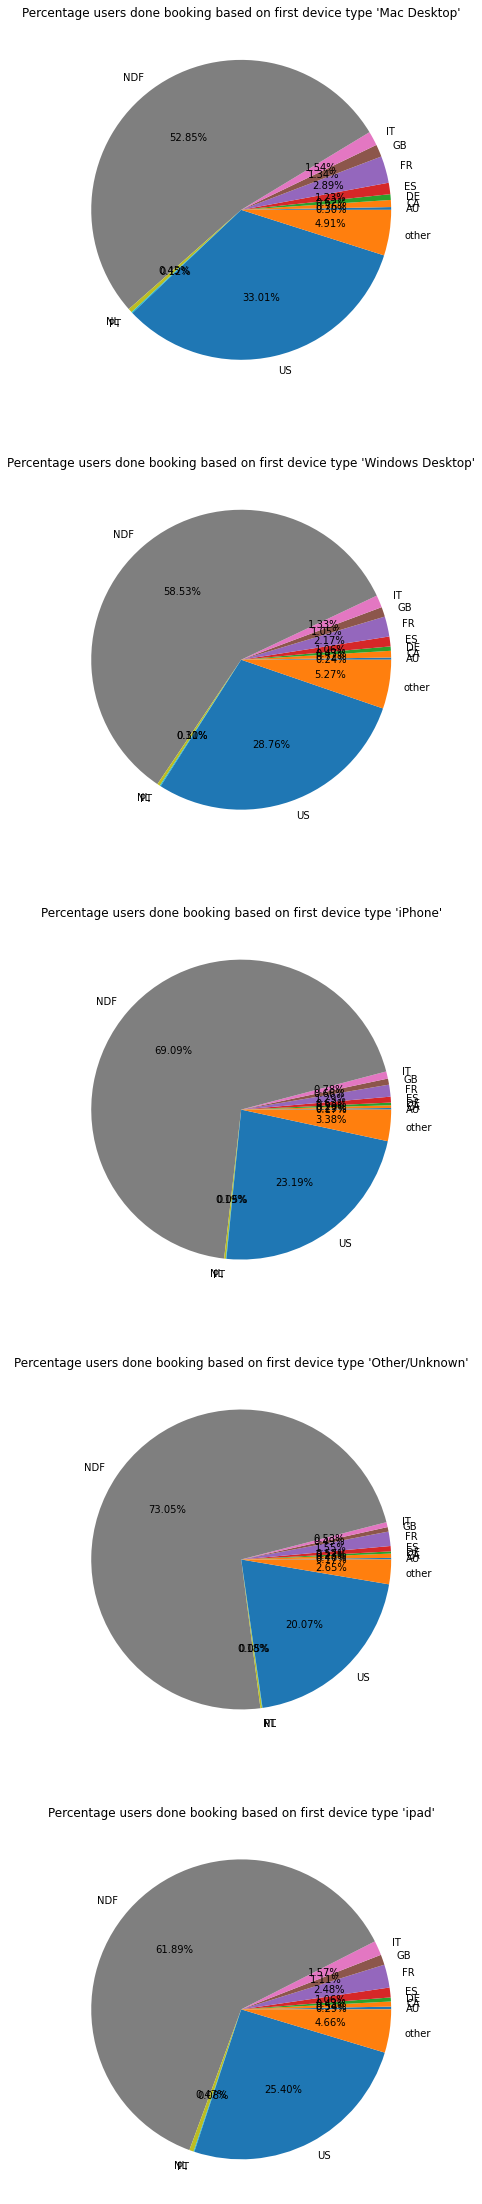

In [ ]:
#Here data_mac_d contains number of users  for each destination where the users use mac desktop. Similarly the list for top 6 contributors are taken  for analysis.

data_mac_d=train_data[train_data['first_device_type']=='Mac Desktop']['country_destination'].value_counts().sort_index()
data_win_d=train_data[train_data['first_device_type']=='Windows Desktop']['country_destination'].value_counts().sort_index()
data_iph=train_data[train_data['first_device_type']=='iPhone']['country_destination'].value_counts().sort_index()
data_ot=train_data[train_data['first_device_type']=='Other/Unknown']['country_destination'].value_counts().sort_index()
data_ipad=train_data[train_data['first_device_type']=='iPad']['country_destination'].value_counts().sort_index()

data=[data_mac_d,data_win_d,data_iph,data_ot,data_ipad]
device_type=['Mac Desktop', 'Windows Desktop', 'iPhone', 'Other/Unknown','ipad']

fig,ax=plt.subplots(5,figsize=(20,20))
fig.set_figheight(40)
fig.set_figwidth(40)
for i in range(ax.shape[0]):
  ax[i].pie(data[i].values,labels=data[i].index,autopct='%1.2f%%')
  ax[i].set_title("Percentage users done booking based on first device type '{}'".format(device_type[i]))

Here we can see a signifiacnt increase in people who use mac desktop make their decision to US. Wherelse many people (69%) who use iphones don't make their bookings (ie NDF) which is higher among the tracked usages.  

#First_browser#

Text(0.5, 1.0, 'Number of users based on thier first browser')

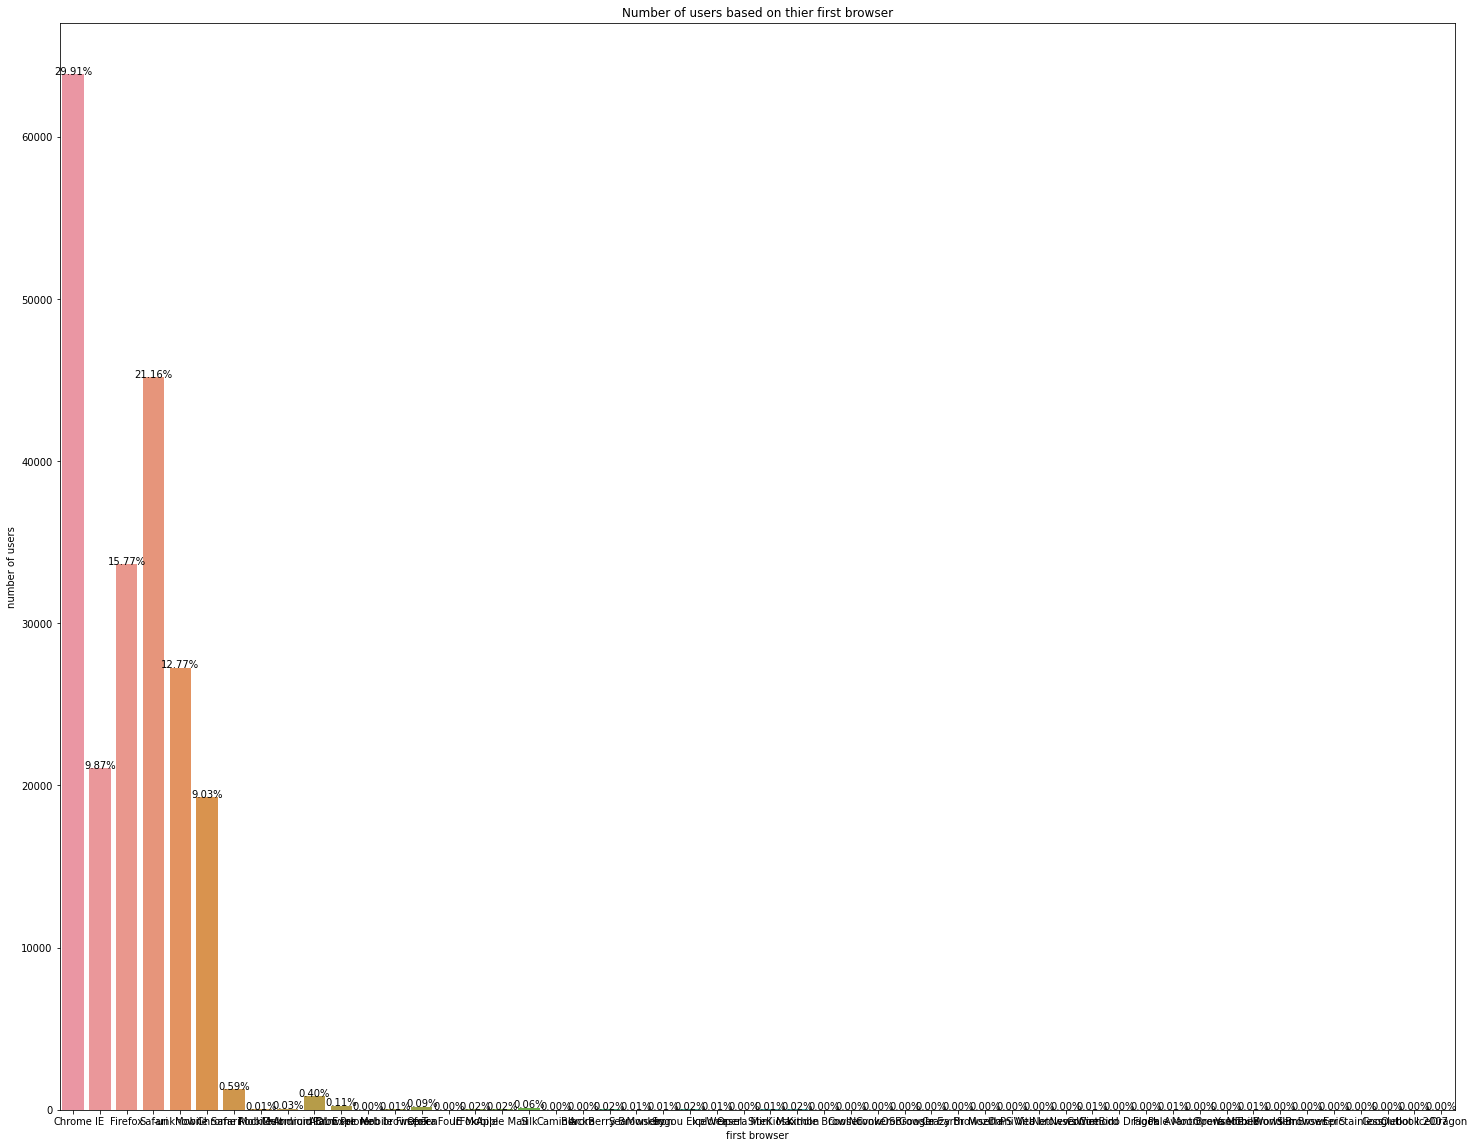

In [ ]:
plt.figure(figsize=(25,20))
ax=sns.countplot(data=train_data,x='first_browser')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.xlabel("first browser")
plt.ylabel("number of users")
plt.title("Number of users based on thier first browser")

Here we could see a large number of browser just contribute less than 0.01%. We can change it to 'Others' for those browser that has the less contribution.

In [ ]:
train_data['first_browser'].value_counts()/train_data.shape[0]*100

Chrome                  29.910846
Safari                  21.161297
Firefox                 15.767085
-unknown-               12.773892
IE                       9.870181
Mobile Safari            9.029707
Chrome Mobile            0.594984
Android Browser          0.398686
AOL Explorer             0.114780
Opera                    0.088076
Silk                     0.058093
Chromium                 0.034200
BlackBerry Browser       0.024830
Maxthon                  0.021551
Apple Mail               0.016866
IE Mobile                0.016866
Sogou Explorer           0.015460
Mobile Firefox           0.014055
SiteKiosk                0.011244
RockMelt                 0.011244
Iron                     0.007964
IceWeasel                0.006090
Pale Moon                0.005622
Yandex.Browser           0.005153
CometBird                0.005153
SeaMonkey                0.005153
Camino                   0.004216
TenFourFox               0.003748
wOSBrowser               0.002811
CoolNovo      

From the above we can see that there are few users using different browsers. We can change that into others.We willtake the data till mobile safari which only have 9.02% of data in the whole daat set. Below them are browser with less than 1% of presence.

In [ ]:
selected_browsers=(train_data['first_browser'].value_counts()/train_data.shape[0]*100).index[:6]
selected_browsers

Index(['Chrome', 'Safari', 'Firefox', '-unknown-', 'IE', 'Mobile Safari'], dtype='object')

In [ ]:
train_data.first_browser=train_data.first_browser.apply(lambda x: 'Other' if x not in selected_browsers else x)

In [ ]:
train_data['first_browser'].value_counts()

Chrome           63845
Safari           45169
Firefox          33655
-unknown-        27266
IE               21068
Mobile Safari    19274
Other             3174
Name: first_browser, dtype: int64

Text(0.5, 1.0, 'Number of users based on thier first browser')

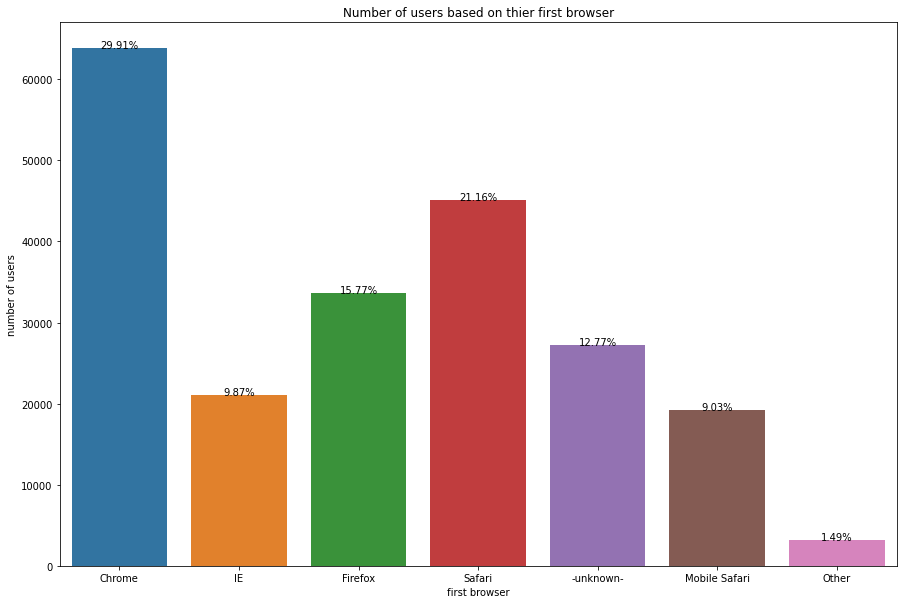

In [ ]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=train_data,x='first_browser')
for p in ax.patches:
  percentage="{:.2f}%".format(100*(p.get_height()/train_data.shape[0]))
  x=p.get_x()+(p.get_width()/2)
  y=p.get_height()
  ax.annotate(percentage,(x,y),ha='center')
plt.xlabel("first browser")
plt.ylabel("number of users")
plt.title("Number of users based on thier first browser")

The above graph shows that many users access the site through chrome which plays a significant part(29.91%) followed by safari and firefox. As we earlier combined all other browser with less contribution we can see that the other browser has a contribution on 1.49% of data.

Let us analyse how this impacts user's decision.

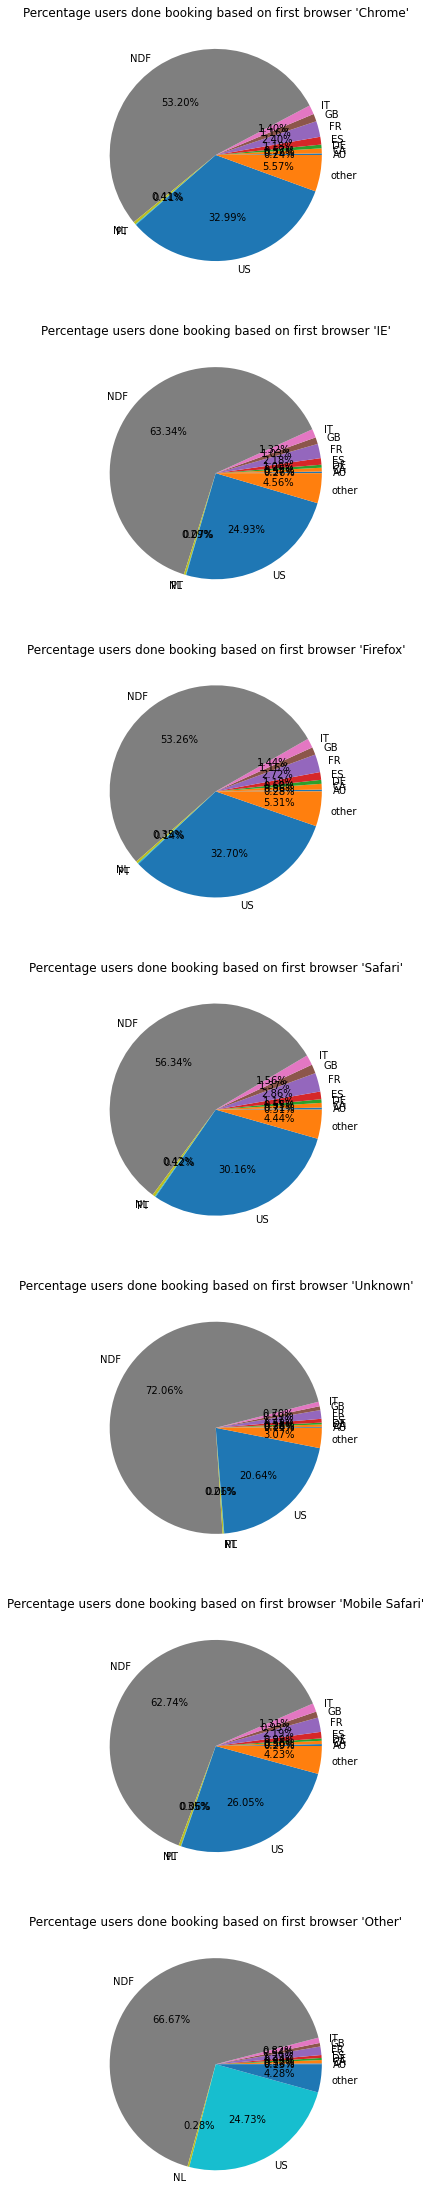

In [ ]:
data_chrome=train_data[train_data['first_browser']=='Chrome']['country_destination'].value_counts().sort_index()
data_ie=train_data[train_data['first_browser']=='IE']['country_destination'].value_counts().sort_index()
data_ff=train_data[train_data['first_browser']=='Firefox']['country_destination'].value_counts().sort_index()
data_sa=train_data[train_data['first_browser']=='Safari']['country_destination'].value_counts().sort_index()
data_unk=train_data[train_data['first_browser']=='-unknown-']['country_destination'].value_counts().sort_index()
data_ms=train_data[train_data['first_browser']=='Mobile Safari']['country_destination'].value_counts().sort_index()
data_ot=train_data[train_data['first_browser']=='Other']['country_destination'].value_counts().sort_index()

data=[data_chrome,data_ie,data_ff,data_sa,data_unk,data_ms,data_ot]
browser=['Chrome', 'IE', 'Firefox','Safari','Unknown','Mobile Safari','Other']

fig,ax=plt.subplots(7,figsize=(20,20))
fig.set_figheight(40)
fig.set_figwidth(40)
for i in range(ax.shape[0]):
  ax[i].pie(data[i].values,labels=data[i].index,autopct='%1.2f%%')
  ax[i].set_title("Percentage users done booking based on first browser '{}'".format(browser[i]))

From the above pie graph we can see that many US prefering people use Chrome, Safari and Firefox.

#Number of Nans#

Text(0.5, 1.0, 'Country preference affected by Number of nans a users have')

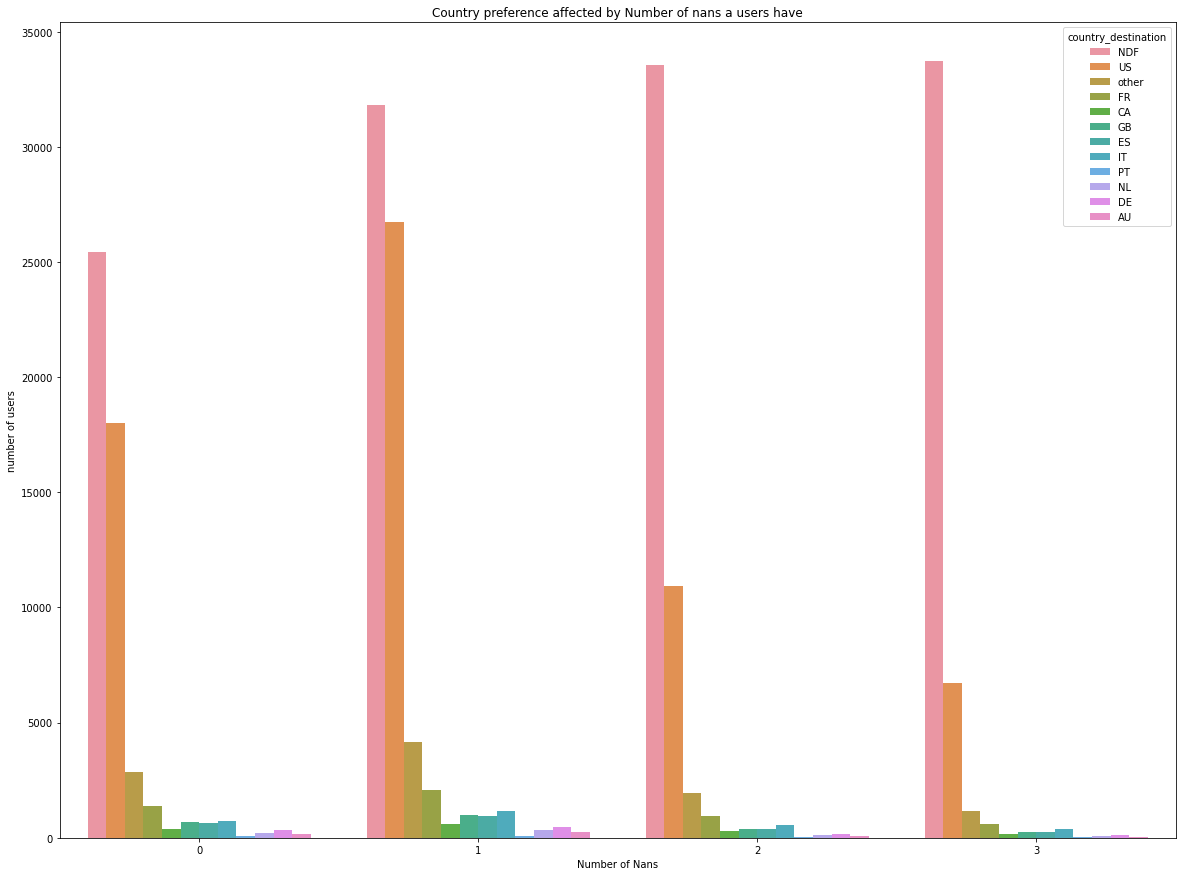

In [ ]:
plt.figure(figsize=(20,15))
ax=sns.countplot(data=train_data,x='no_of_nans',hue='country_destination')
plt.xlabel("Number of Nans")
plt.ylabel("number of users")
plt.title("Country preference affected by Number of nans a users have")

Here we can see that when there are more number of nans for a user most of the user doesn't make any bookings. We can see that for a person who have 0 or 1 nan value in their data considerable users make their bookings to US compared to those users who have 2 and 3 nan values. This feature could be much helpful for our prediction.

#For test users#

Now let us do the preprocessing to test users that are done to trainning data.

In [ ]:
test_data.isna().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [ ]:
test_data['date_account_created']=pd.to_datetime(test_data['date_account_created'])
test_data['year_account_created']=pd.DatetimeIndex(test_data['date_account_created']).year
test_data['month_account_created']=pd.DatetimeIndex(test_data['date_account_created']).month
test_data['day_account_created']=pd.DatetimeIndex(test_data['date_account_created']).dayofweek

test_data['timestamp_first_active']=pd.to_datetime(test_data['timestamp_first_active'],format='%Y%m%d%H%M%S')
test_data['year_first_active']=pd.DatetimeIndex(test_data['timestamp_first_active']).year
test_data['month_first_active']=pd.DatetimeIndex(test_data['timestamp_first_active']).month
test_data['day_first_active']=pd.DatetimeIndex(test_data['timestamp_first_active']).dayofweek
test_data['hour_first_active']=pd.DatetimeIndex(test_data['timestamp_first_active']).hour

In [ ]:
for i in range(len(test_data['age'])):
  if test_data['age'][i]>150 and test_data['age'][i]<2010:
    test_data['age'][i]=test_data['year_account_created'][i]-test_data['age'][i]

In [ ]:
test_data.age=test_data.age.apply(lambda x: 115 if x>115 else x)
test_data.age=test_data.age.apply(lambda x: 15 if x<15 else x)
test_data.age.fillna(-1,inplace=True)

In [ ]:
test_data['age_bucket']=test_data.age.apply(lambda x:age_to_bucket(x))

In [ ]:
test_data['first_affiliate_tracked'].fillna('unknown',inplace=True)

In [ ]:
test_data.language=test_data.language.apply(lambda x: 'Other' if x not in selected_language else x)
test_data.first_browser=test_data.first_browser.apply(lambda x: 'Other' if x not in selected_browsers else x)
test_data.affiliate_provider=test_data.affiliate_provider.apply(lambda x: 'smallcontribution' if x not in selected_aff_provider else x)
test_data.first_affiliate_tracked=test_data.first_affiliate_tracked.apply(lambda x: 'others' if x not in selected_aff_track else x)

In [ ]:
test_data['no_of_nans']=0

for i in range(len(test_data)):
  if test_data['age'][i]==-1:
    test_data['no_of_nans'][i]+=1

  if test_data['gender'][i]=='-unknown-':
    test_data['no_of_nans'][i]+=1

  if test_data['first_affiliate_tracked'][i]=='untracked':
    test_data['no_of_nans'][i]+=1

In [ ]:
print(len(test_data.keys()))
print(len(train_data.keys()))

24
25


#Eliminating some features of Users data#

Since we are going to merge train users data with that of sessions data we may have to remove certain features. We will be removing features like year_account_created, month_account_created, year_first_active, month_first_active. This is because in seesions dataset we have data where year_account created will start from 1/1/2014. Due to this we may train data that only have the year 2014. Also during training we may encounter months from 1 to 6 and in test data we encounter months from 6 to 12. Here we could not use months because we train on  months that doesn't coincide with test dataset's month. We will also eliminate date_first_booking column because in test data we are not provided any data to this column. 

In [ ]:
train_data.keys()

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination', 'year_account_created',
       'month_account_created', 'day_account_created', 'year_first_active',
       'month_first_active', 'day_first_active', 'hour_first_active',
       'no_of_nans', 'age_bucket'],
      dtype='object')

In [ ]:
test_data.keys()

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'year_account_created', 'month_account_created',
       'day_account_created', 'year_first_active', 'month_first_active',
       'day_first_active', 'hour_first_active', 'age_bucket', 'no_of_nans'],
      dtype='object')

In [ ]:
columns_to_eliminate=['date_account_created','timestamp_first_active',
                      'date_first_booking','year_account_created',
                      'month_account_created','year_first_active',
                      'month_first_active']

In [ ]:
train_data.drop(labels=columns_to_eliminate,axis=1,inplace=True)
test_data.drop(labels=columns_to_eliminate,axis=1,inplace=True)

In [ ]:
train_data.keys()

Index(['id', 'gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination', 'day_account_created', 'day_first_active',
       'hour_first_active', 'no_of_nans', 'age_bucket'],
      dtype='object')

In [ ]:
train_data.shape

(213451, 18)

In [ ]:
test_data.shape

(62096, 17)

#Splitting into train data and cross validation#

First we pick dataset that are in sessions dataset(ie id in train_users and user id in sessions).

In [ ]:
train_data=train_data.merge(sessions_data['user_id'].drop_duplicates(),right_on='user_id',left_on='id',how='inner').drop(['user_id'],axis=1)

In [ ]:
train_data

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,day_account_created,day_first_active,hour_first_active,no_of_nans,age_bucket
0,d1mm9tcy42,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,2,2,0,0,bucket10
1,yo8nz8bqcq,-unknown-,-1.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,2,2,0,3,nullbucket
2,4grx6yxeby,-unknown-,-1.0,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,2,2,0,2,nullbucket
3,ncf87guaf0,-unknown-,-1.0,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,2,2,0,2,nullbucket
4,4rvqpxoh3h,-unknown-,-1.0,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,2,2,0,3,nullbucket
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73810,zxodksqpep,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,0,0,23,0,bucket4
73811,mhewnxesx9,-unknown-,-1.0,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,0,0,23,2,nullbucket
73812,6o3arsjbb4,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,0,0,23,2,bucket4
73813,jh95kwisub,-unknown-,-1.0,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF,0,0,23,2,nullbucket


In [ ]:
print("Shape of the new train data:",train_data.shape)

Shape of the new train data: (73815, 18)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_cv=train_test_split(train_data,test_size=0.15,stratify=train_data['country_destination'],random_state=42)

In [ ]:
print(X_train.shape)
print(X_cv.shape)

(62742, 18)
(11073, 18)


#Feature Engineering for users data#

In [ ]:
%cd /content/drive/MyDrive/Airbnb trail

/content/drive/MyDrive/Airbnb trail


###One hot encoding Categorical features###

Categorical features are one hot encoded.  

In [ ]:
ohe=OneHotEncoder()
ohe.fit(X_train['age_bucket'].values.reshape(-1,1))
age_bucket_train_ohe=ohe.transform(X_train['age_bucket'].values.reshape(-1,1))
age_bucket_cv_ohe=ohe.transform(X_cv['age_bucket'].values.reshape(-1,1))
age_bucket_test_ohe=ohe.transform(test_data['age_bucket'].values.reshape(-1,1))

age_bucket_train_ohe=pd.DataFrame(age_bucket_train_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
age_bucket_cv_ohe=pd.DataFrame(age_bucket_cv_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
age_bucket_test_ohe=pd.DataFrame(age_bucket_test_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)

dump(ohe,'age_bucket_ohe.bin',compress=True)

['age_bucket_ohe.bin']

In [ ]:
ohe=OneHotEncoder()
ohe.fit(X_train['gender'].values.reshape(-1,1))
gender_train_ohe=ohe.transform(X_train['gender'].values.reshape(-1,1))
gender_cv_ohe=ohe.transform(X_cv['gender'].values.reshape(-1,1))
gender_test_ohe=ohe.transform(test_data['gender'].values.reshape(-1,1))

gender_train_ohe=pd.DataFrame(gender_train_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
gender_cv_ohe=pd.DataFrame(gender_cv_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
gender_test_ohe=pd.DataFrame(gender_test_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)

dump(ohe,'gender_ohe.bin',compress=True)

['gender_ohe.bin']

In [ ]:
ohe=OneHotEncoder()
ohe.fit(X_train['language'].values.reshape(-1,1))
language_train_ohe=ohe.transform(X_train['language'].values.reshape(-1,1))
language_cv_ohe=ohe.transform(X_cv['language'].values.reshape(-1,1))
language_test_ohe=ohe.transform(test_data['language'].values.reshape(-1,1))

language_train_ohe=pd.DataFrame(language_train_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
language_cv_ohe=pd.DataFrame(language_cv_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
language_test_ohe=pd.DataFrame(language_test_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)

dump(ohe,'language_ohe.bin',compress=True)

['language_ohe.bin']

In [ ]:
ohe=OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train['signup_method'].values.reshape(-1,1))
sign_up_method_train_ohe=ohe.transform(X_train['signup_method'].values.reshape(-1,1))
sign_up_method_cv_ohe=ohe.transform(X_cv['signup_method'].values.reshape(-1,1))
sign_up_method_test_ohe=ohe.transform(test_data['signup_method'].values.reshape(-1,1))

sign_up_method_train_ohe=pd.DataFrame(sign_up_method_train_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
sign_up_method_cv_ohe=pd.DataFrame(sign_up_method_cv_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
sign_up_method_test_ohe=pd.DataFrame(sign_up_method_test_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)

dump(ohe,'signup_method_ohe.bin',compress=True)

['signup_method_ohe.bin']

In 'signup_method' feature it was intresting to see that in test data some users signed up to the site using wiebo credentials which was not in the train set. In such case we ignore those category value.

In [ ]:
ohe=OneHotEncoder()
ohe.fit(X_train['affiliate_channel'].values.reshape(-1,1))
affliate_channel_train_ohe=ohe.transform(X_train['affiliate_channel'].values.reshape(-1,1))
affliate_channel_cv_ohe=ohe.transform(X_cv['affiliate_channel'].values.reshape(-1,1))
affliate_channel_test_ohe=ohe.transform(test_data['affiliate_channel'].values.reshape(-1,1))

affliate_channel_train_ohe=pd.DataFrame(affliate_channel_train_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
affliate_channel_cv_ohe=pd.DataFrame(affliate_channel_cv_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
affliate_channel_test_ohe=pd.DataFrame(affliate_channel_test_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)

dump(ohe,'affiliate_channel_ohe.bin',compress=True)

['affiliate_channel_ohe.bin']

In [ ]:
ohe=OneHotEncoder()
ohe.fit(X_train['affiliate_provider'].values.reshape(-1,1))
affliate_provider_train_ohe=ohe.transform(X_train['affiliate_provider'].values.reshape(-1,1))
affliate_provider_cv_ohe=ohe.transform(X_cv['affiliate_provider'].values.reshape(-1,1))
affliate_provider_test_ohe=ohe.transform(test_data['affiliate_provider'].values.reshape(-1,1))

affliate_provider_train_ohe=pd.DataFrame(affliate_provider_train_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
affliate_provider_cv_ohe=pd.DataFrame(affliate_provider_cv_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
affliate_provider_test_ohe=pd.DataFrame(affliate_provider_test_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)

dump(ohe,'affiliate_provider_ohe.bin',compress=True)

['affiliate_provider_ohe.bin']

In [ ]:
ohe=OneHotEncoder()
ohe.fit(X_train['first_affiliate_tracked'].values.reshape(-1,1))
first_affliate_tracked_train_ohe=ohe.transform(X_train['first_affiliate_tracked'].values.reshape(-1,1))
first_affliate_tracked_cv_ohe=ohe.transform(X_cv['first_affiliate_tracked'].values.reshape(-1,1))
first_affliate_tracked_test_ohe=ohe.transform(test_data['first_affiliate_tracked'].values.reshape(-1,1))

first_affliate_tracked_train_ohe=pd.DataFrame(first_affliate_tracked_train_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
first_affliate_tracked_cv_ohe=pd.DataFrame(first_affliate_tracked_cv_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
first_affliate_tracked_test_ohe=pd.DataFrame(first_affliate_tracked_test_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)

dump(ohe,'first_affliate_tracked_ohe.bin',compress=True)

['first_affliate_tracked_ohe.bin']

In [ ]:
ohe=OneHotEncoder()
ohe.fit(X_train['signup_app'].values.reshape(-1,1))
signup_app_train_ohe=ohe.transform(X_train['signup_app'].values.reshape(-1,1))
signup_app_cv_ohe=ohe.transform(X_cv['signup_app'].values.reshape(-1,1))
signup_app_test_ohe=ohe.transform(test_data['signup_app'].values.reshape(-1,1))

signup_app_train_ohe=pd.DataFrame(signup_app_train_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
signup_app_cv_ohe=pd.DataFrame(signup_app_cv_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
signup_app_test_ohe=pd.DataFrame(signup_app_test_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)

dump(ohe,'signup_app_ohe.bin',compress=True)

['signup_app_ohe.bin']

In [ ]:
ohe=OneHotEncoder()
ohe.fit(X_train['first_device_type'].values.reshape(-1,1))
first_device_type_train_ohe=ohe.transform(X_train['first_device_type'].values.reshape(-1,1))
first_device_type_cv_ohe=ohe.transform(X_cv['first_device_type'].values.reshape(-1,1))
first_device_type_test_ohe=ohe.transform(test_data['first_device_type'].values.reshape(-1,1))

first_device_type_train_ohe=pd.DataFrame(first_device_type_train_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
first_device_type_cv_ohe=pd.DataFrame(first_device_type_cv_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
first_device_type_test_ohe=pd.DataFrame(first_device_type_test_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)

dump(ohe,'first_device_type_ohe.bin',compress=True)

['first_device_type_ohe.bin']

In [ ]:
ohe=OneHotEncoder()
ohe.fit(X_train['first_browser'].values.reshape(-1,1))
first_browser_train_ohe=ohe.transform(X_train['first_browser'].values.reshape(-1,1))
first_browser_cv_ohe=ohe.transform(X_cv['first_browser'].values.reshape(-1,1))
first_browser_test_ohe=ohe.transform(test_data['first_browser'].values.reshape(-1,1))

first_browser_train_ohe=pd.DataFrame(first_browser_train_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
first_browser_cv_ohe=pd.DataFrame(first_browser_cv_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)
first_browser_test_ohe=pd.DataFrame(first_browser_test_ohe.todense(),columns=ohe.get_feature_names()).astype(np.int)

dump(ohe,'first_browser_ohe.bin',compress=True)

['first_browser_ohe.bin']

#Combining#

Now we combine all the preprocessing that have been done to training data.

In [ ]:
from scipy import sparse
preprocessed_train=pd.concat([age_bucket_train_ohe,gender_train_ohe,language_train_ohe,
                              sign_up_method_train_ohe,affliate_channel_train_ohe,affliate_provider_train_ohe,
                              first_affliate_tracked_train_ohe,signup_app_train_ohe,first_device_type_train_ohe,
                              first_browser_train_ohe],axis=1
                              )
preprocessed_cv=pd.concat([age_bucket_cv_ohe,gender_cv_ohe,language_cv_ohe,
                          sign_up_method_cv_ohe,affliate_channel_cv_ohe,affliate_provider_cv_ohe,
                          first_affliate_tracked_cv_ohe,signup_app_cv_ohe,first_device_type_cv_ohe,
                          first_browser_cv_ohe],axis=1
                          )
preprocessed_test=pd.concat([age_bucket_test_ohe,gender_test_ohe,language_test_ohe,
                            sign_up_method_test_ohe,affliate_channel_test_ohe,affliate_provider_test_ohe,
                            first_affliate_tracked_test_ohe,signup_app_test_ohe,first_device_type_test_ohe,
                            first_browser_test_ohe],axis=1
                            )

In [ ]:
X_train.reset_index(inplace=True)
X_cv.reset_index(inplace=True)
test_data.reset_index(inplace=True)

In [ ]:
X_train.drop('index',axis=1,inplace=True)
X_cv.drop('index',axis=1,inplace=True)
test_data.drop('index',axis=1,inplace=True)

In [ ]:
print(X_train.shape)
print(X_cv.shape)
print(test_data.shape)

(62742, 18)
(11073, 18)
(62096, 17)


In [ ]:
print(preprocessed_train.shape)
print(preprocessed_cv.shape)
print(preprocessed_test.shape)

(62742, 86)
(11073, 86)
(62096, 86)


Now let us combine the feature engineered data with the respective id and country destination for train, cv data and test data.

In [ ]:
train_fe=pd.concat([X_train[['id','country_destination','day_account_created',
                             'day_first_active','hour_first_active',
                             'signup_flow','age','no_of_nans']],preprocessed_train],axis=1,join='inner')
cv_fe=pd.concat([X_cv[['id','country_destination','day_account_created',
                      'day_first_active','hour_first_active',
                      'signup_flow','age','no_of_nans']],preprocessed_cv],axis=1,join='inner')
test_fe=pd.concat([test_data[['id','day_account_created',
                             'day_first_active','hour_first_active',
                             'signup_flow','age','no_of_nans']],preprocessed_test],axis=1,join='inner')

In [ ]:
print(train_fe.shape)
print(cv_fe.shape)
print(test_fe.shape)

(62742, 94)
(11073, 94)
(62096, 93)


In [ ]:
print(train_fe.isna().values.sum())
print(cv_fe.isna().values.sum())
print(test_fe.isna().values.sum())

0
0
0


#Saving necessary variables#

In [ ]:
%cd /content/drive/MyDrive/Airbnb trail

/content/drive/MyDrive/Airbnb trail


In [ ]:
train_fe.to_csv('Train_feature_engineered.csv')
cv_fe.to_csv('Cv_feature_engineered.csv')
test_fe.to_csv('Test_feature_engineered.csv')

In [ ]:
np.save('selected_language.npz',selected_language)
np.save('selected_browsers.npz',selected_browsers)
np.save('selected_aff_provider.npz',selected_aff_provider)
np.save('selected_aff_track.npz',selected_aff_track)